# PEEC - Estimation of the effect of lensing in photometric galaxy surveys 

PyCCL documentation - https://ccl.readthedocs.io/en/latest/api/pyccl.cosmology.html#pyccl.cosmology.Cosmology.correlation_3d

PyCCL code - https://github.com/LSSTDESC/CCLX/blob/master/Angular%20cross-correlations.ipynb

$$\begin{split}
    w^{ab}(\theta) = \sum_l \frac{2l+1}{4\pi} C_l^{ab} P_l(\cos\theta)\\
\end{split}$$

$$\begin{split}
    C^{ab}_l = 4\pi \int_0^{+\infty} \frac{P_\phi(k)}{k} \Delta_l^{NC, a} \Delta_l^{NC, b} \;dk\\
\end{split}$$

$$\begin{split}
    \Delta^{NC} \equiv \Delta^D + \Delta^{RSD} + \Delta^{LM}\\
\end{split}$$

In [2]:
import numpy as np
import scipy as sc
import pyccl as ccl
import matplotlib.pyplot as plt
import math
import time
import camb
import sys, platform, os
from camb import model, initialpower
print(F'Using CAMB {camb.__version__} installed at {os.path.dirname(camb.__file__)}')

#Get angular power spectrum for galaxy number counts and lensing
from camb.sources import GaussianSourceWindow, SplinedSourceWindow

T0 = time.time()
# from icecream import ic

SMALL_SIZE  = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Using CAMB 1.5.4 installed at /home/tiago_sinde/miniconda3/envs/Linux_env/lib/python3.12/site-packages/camb


### 3D Correlation function - $\xi(r)$

Cosmology object has stored P(K) = True


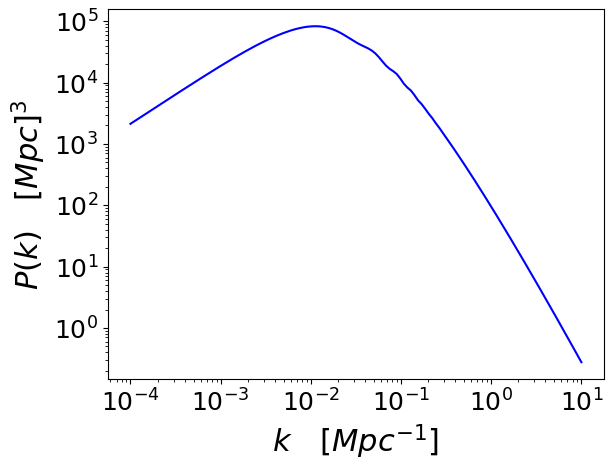


sigma8 = 0.8402187282371845


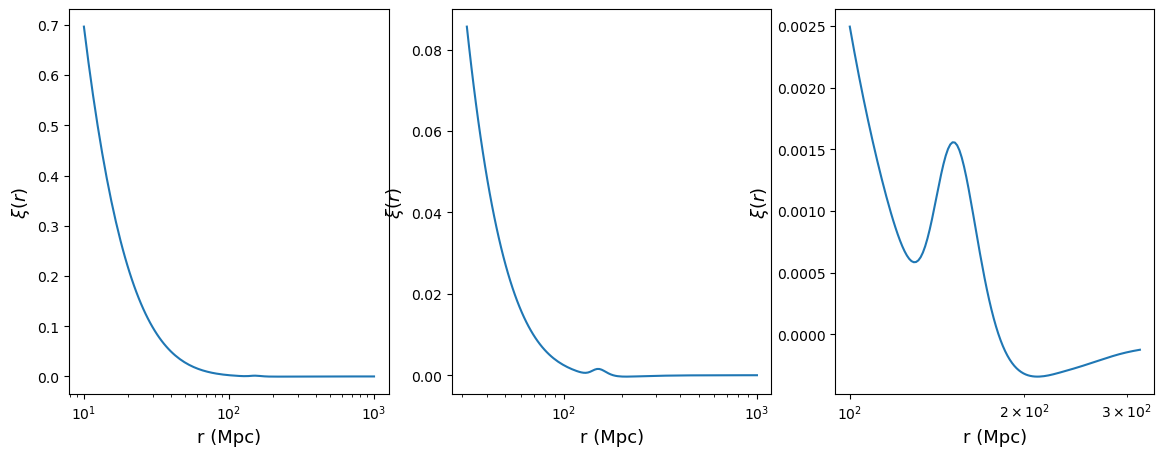

In [2]:
# Define a set of cosmological parameters
cosmo3D = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1*10**-9, n_s=0.96)


# Define wavenumber, k, and scale factor, a
kmin, kmax, nk = 10**-4, 10, 128
ks = np.logspace(np.log10(kmin), np.log10(kmax), nk) # Wavenumber
a_0 = 1.0 # Scale factor a(t_0)=1

# Determine the linear Power spectrum for this cosmological parameters
Pk_lin = ccl.linear_matter_power(cosmo3D, ks, a_0)   # this saves the linear P(k) in this cosmology object
print("Cosmology object has stored P(K) =",cosmo3D.has_linear_power)

plt.plot(ks, Pk_lin, 'b-')
# plt.plot(k, pk_nl, 'r-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k\quad[Mpc^{-1}]$', fontsize = 22)
plt.ylabel(r'$P(k)\quad[Mpc]^3$', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Power Spectrum normalization, sigma8
ccl.sigma8(cosmo3D)
print("\nsigma8 =",cosmo3D['sigma8'])

# Helper to retrieve the right Pk2D object.
Pk2D = ccl.parse_pk(cosmo3D)  

rs1 = np.logspace(1, 3, nk)  # in Mpc
rs2 = np.logspace(1.5, 3, nk)
rs3 = np.logspace(2, 2.5, nk)

xi_3D_1 = ccl.correlation_3d(cosmo3D, r=rs1, a=a_0, p_of_k_a=Pk2D ) 
xi_3D_2 = ccl.correlation_3d(cosmo3D, r=rs2, a=a_0, p_of_k_a=Pk2D ) 
xi_3D_3 = ccl.correlation_3d(cosmo3D, r=rs3, a=a_0, p_of_k_a=Pk2D ) 

fig, axis = plt.subplots(ncols=3,nrows=1,figsize=(14,5))
axis[0].plot(rs1, xi_3D_1, label='Clustering')
axis[0].set_xscale('log')
axis[0].set_xlabel(r'r (Mpc)',fontsize=13)
axis[0].set_ylabel(r'$\xi (r)$',fontsize=13)
axis[1].plot(rs2, xi_3D_2, label='Clustering')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'r (Mpc)',fontsize=13)
axis[1].set_ylabel(r'$\xi (r)$',fontsize=13)
axis[2].plot(rs3, xi_3D_3, label='Clustering')
axis[2].set_xscale('log')
axis[2].set_xlabel(r'r (Mpc)',fontsize=13)
axis[2].set_ylabel(r'$\xi (r)$',fontsize=13)
plt.show()

### Angular correlation function $w(\theta)$

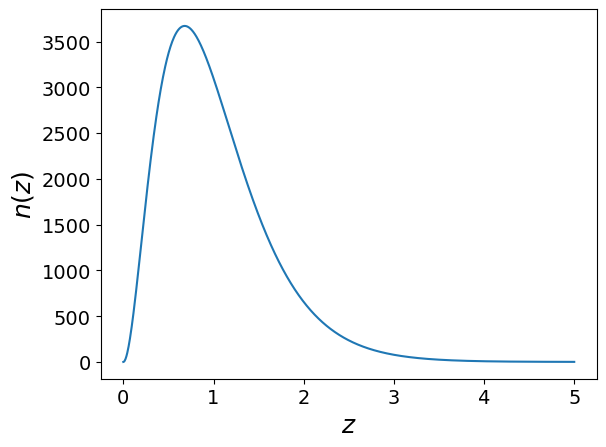

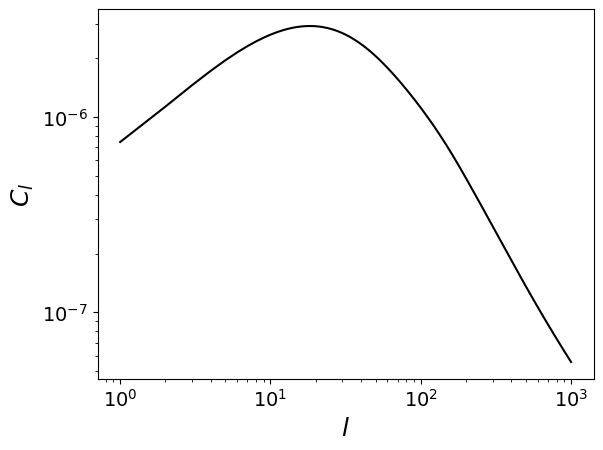

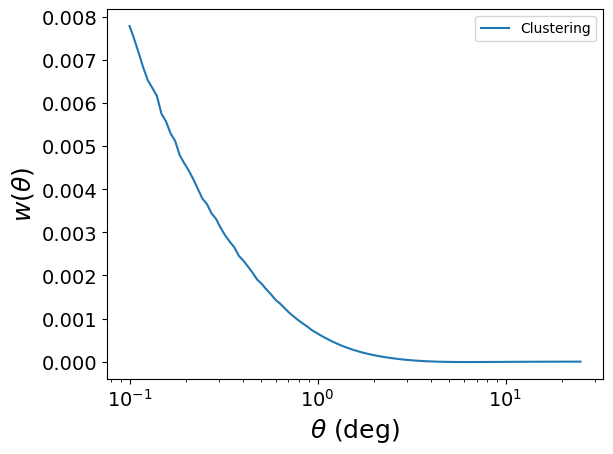

In [3]:
# Definir um tipo de Universo
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)


# Definir uma Distribuição de Galáxias
z = np.linspace(0, 5, 1024)
i_lim = 26.0 # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744 # Constant, used to mimic observation

Ngal = 46. * 100.31  * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution
b = 1.5*np.ones(1024) #Galaxy bias (constant with scale and z)

plt.xlabel('$z$',fontsize=18)
plt.ylabel('$n(z)$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(z, dNdz)
plt.show()


# Criar tracers 
lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz)) #CCL automatically normalizes dNdz
clu1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))


# Calcular Poderes espectrais angulares
ells = np.arange(1, 1000)
cls_cluster = ccl.angular_cl(cosmo, clu1, clu1, ells) #Clustering

plt.xlabel('$l$',fontsize=18)
plt.ylabel('$C_l$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ells, cls_cluster, 'k-')
plt.show()


# Calcular Função de correlação
thetas = np.logspace(-1, np.log10(25), 100) # Theta is in degrees
#print("thetas =", thetas)
cosmo2 = cosmo        # A Cosmology object.
ell2 = ells           # Multipoles corresponding to the input angular power spectrum.
C_ell2 = cls_cluster  # Input angular power spectrum.
theta2 = thetas       # Angular separation(s) at which to calculate the angular correlation function (in degrees).
type = "NN"           # Type of correlation function. In this case matter, galaxies
method = "fftlog"     # Method to compute the correlation function.

w_cluster = ccl.correlation(cosmo2, ell=ell2, C_ell=C_ell2, theta=theta2, type='NN', method='fftlog')

plt.plot(thetas, w_cluster, label='Clustering')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)',fontsize=18)
plt.ylabel(r'$w (\theta)$',fontsize=18)
plt.show()

### Usar os 3 tracers do Number Counts

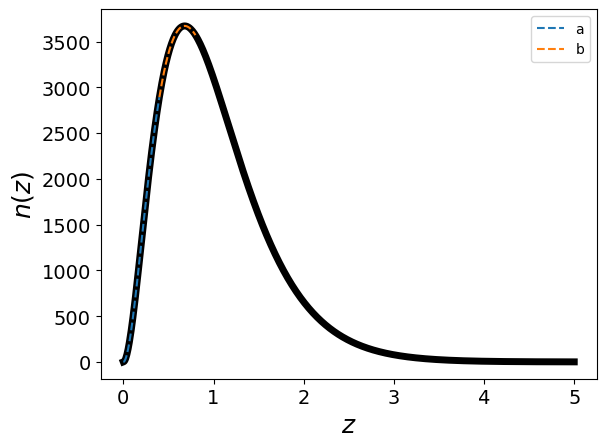

In [4]:
# Definir um tipo de Universo
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)

# Definir uma Distribuição de Galáxias
i_lim = 26.0 # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744 # Constant, used to mimic observation
Ngal = 46. * 100.31  * (i_lim - 25.) # Normalisation, galaxies/arcmin^2

# Redshift distribution, p(z)
def p_z(z, z_0):
    return 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0)

Npts = 750
arr_z = np.linspace(0, 5, Npts)
pz0 = p_z(arr_z, z0)
dNdz0 = Ngal * pz0 # Number density distribution

arr_z1 = np.linspace(0, 0.4, Npts)
pz1 = p_z(arr_z1, z0)
dNdz1 = Ngal * pz1 # Number density distribution
b_z1 = 1*np.ones(Npts) #Galaxy bias (constant with scale and z)
s_z1 = 1*np.ones(Npts) #Lensing bias (constant with scale and z)

Npts2 = 750
arr_z2 = np.linspace(0.4, 0.8, Npts2)
pz2 = p_z(arr_z2, z0)
dNdz2 = Ngal * pz2 # Number density distribution
b_z2 = 1*np.ones(Npts2) #Galaxy bias (constant with scale and z)
s_z2 = 1*np.ones(Npts2) #Lensing bias (constant with scale and z)


plt.xlabel('$z$',fontsize=18)
plt.ylabel('$n(z)$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(arr_z,dNdz0, linewidth = 5, color="k")
plt.plot(arr_z1, dNdz1, "--", label="a")
plt.plot(arr_z2, dNdz2, "--", label="b")
plt.legend()
plt.show()

In [5]:
# Criar tracers 
Tracer_NC_D_a       = ccl.NumberCountsTracer(cosmo, dndz=(arr_z1,dNdz1), bias=(arr_z1,b_z1), mag_bias = None, has_rsd=False, n_samples=Npts)
Tracer_NC_D_RSD_a   = ccl.NumberCountsTracer(cosmo, dndz=(arr_z1,dNdz1), bias=(arr_z1,b_z1), mag_bias = None, has_rsd=True, n_samples=Npts)
Tracer_NC_D_RSD_L_a = ccl.NumberCountsTracer(cosmo, dndz=(arr_z1,dNdz1), bias=(arr_z1,b_z1), mag_bias = (arr_z1,s_z1), has_rsd=True, n_samples=Npts)

Tracer_NC_D_b       = ccl.NumberCountsTracer(cosmo, dndz=(arr_z2,dNdz2), bias=(arr_z2,b_z2), mag_bias = None, has_rsd=False, n_samples=Npts2)
Tracer_NC_D_RSD_b   = ccl.NumberCountsTracer(cosmo, dndz=(arr_z2,dNdz2), bias=(arr_z2,b_z2), mag_bias = None, has_rsd=True, n_samples=Npts2)
Tracer_NC_D_RSD_L_b = ccl.NumberCountsTracer(cosmo, dndz=(arr_z2,dNdz2), bias=(arr_z2,b_z2), mag_bias = (arr_z2,s_z2), has_rsd=True, n_samples=Npts2)


# Calcular Poderes espectrais angulares
ells = np.arange(1, 2*10**3)
cls_D_aa       = ccl.angular_cl(cosmo, Tracer_NC_D_a, Tracer_NC_D_a, ells)
cls_D_RSD_aa   = ccl.angular_cl(cosmo, Tracer_NC_D_RSD_a, Tracer_NC_D_RSD_a, ells) 
cls_D_RSD_L_aa = ccl.angular_cl(cosmo, Tracer_NC_D_RSD_L_a, Tracer_NC_D_RSD_L_a, ells)

cls_D_ab       = ccl.angular_cl(cosmo, Tracer_NC_D_a, Tracer_NC_D_b, ells)
cls_D_RSD_ab   = ccl.angular_cl(cosmo, Tracer_NC_D_RSD_a, Tracer_NC_D_RSD_b, ells) 
cls_D_RSD_L_ab = ccl.angular_cl(cosmo, Tracer_NC_D_RSD_L_a, Tracer_NC_D_RSD_L_b, ells)

cls_D_bb       = ccl.angular_cl(cosmo, Tracer_NC_D_b, Tracer_NC_D_b, ells)
cls_D_RSD_bb   = ccl.angular_cl(cosmo, Tracer_NC_D_RSD_b, Tracer_NC_D_RSD_b, ells) 
cls_D_RSD_L_bb = ccl.angular_cl(cosmo, Tracer_NC_D_RSD_L_b, Tracer_NC_D_RSD_L_b, ells) 

# Calcular Função de correlação
thetas = np.logspace(-1, np.log10(15), 1000) # Theta is in degrees
w_D_aa       = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_aa, theta=thetas, type='NN', method='fftlog')
w_D_RSD_aa   = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_RSD_aa, theta=thetas, type='NN', method='fftlog')
w_D_RSD_L_aa = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_RSD_L_aa, theta=thetas, type='NN', method='fftlog')

w_D_ab       = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_ab, theta=thetas, type='NN', method='fftlog')
w_D_RSD_ab   = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_RSD_ab, theta=thetas, type='NN', method='fftlog')
w_D_RSD_L_ab = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_RSD_L_ab, theta=thetas, type='NN', method='fftlog')

w_D_bb       = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_bb, theta=thetas, type='NN', method='fftlog')
w_D_RSD_bb   = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_RSD_bb, theta=thetas, type='NN', method='fftlog')
w_D_RSD_L_bb = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_RSD_L_bb, theta=thetas, type='NN', method='fftlog')

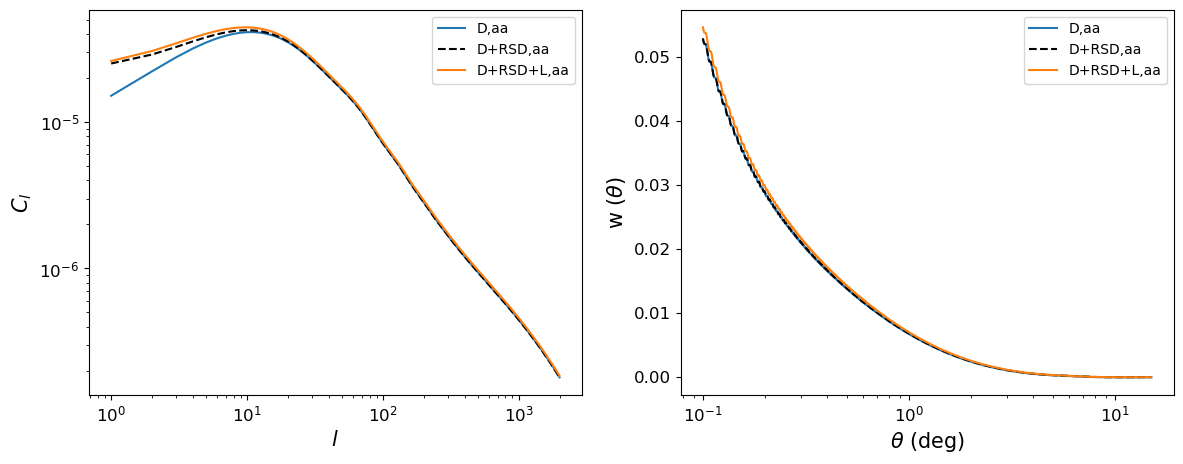

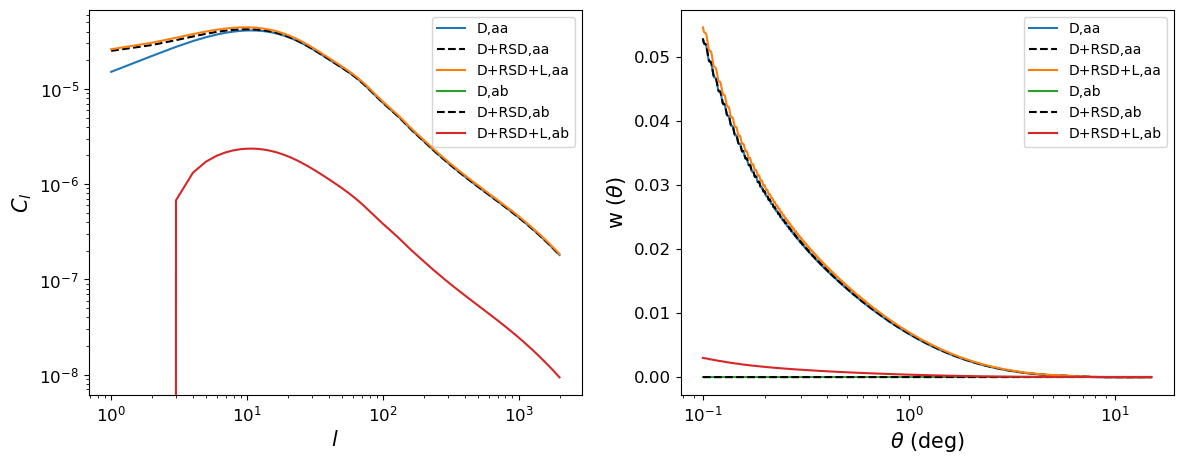

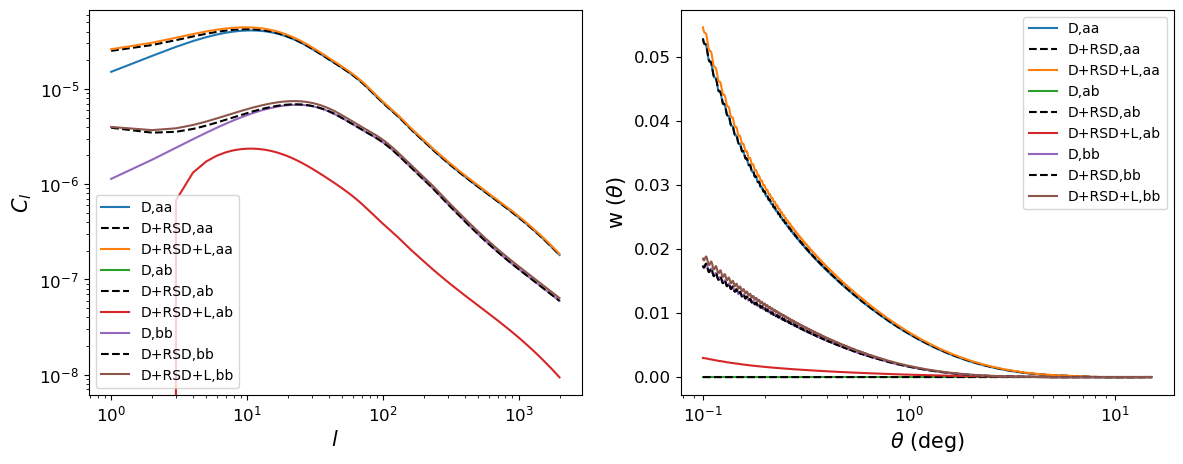

In [6]:
# Visualizing
fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, cls_D_aa, label="D,aa")
axis[0].plot(ells, cls_D_RSD_aa, "--", color="k", label="D+RSD,aa")
axis[0].plot(ells, cls_D_RSD_L_aa, label="D+RSD+L,aa")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$',fontsize=15)
axis[0].set_ylabel('$C_l$',fontsize=15)
axis[0].tick_params(axis='x', labelsize=12)
axis[0].tick_params(axis='y', labelsize=12)
axis[0].legend()

axis[1].plot(thetas, w_D_aa, label='D,aa')
axis[1].plot(thetas, w_D_RSD_aa,"--", color="k",label='D+RSD,aa')
axis[1].plot(thetas, w_D_RSD_L_aa,label='D+RSD+L,aa')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)',fontsize=15)
axis[1].set_ylabel(r'w $(\theta)$',fontsize=15)
axis[1].tick_params(axis='x', labelsize=12)
axis[1].tick_params(axis='y', labelsize=12)
axis[1].legend()
plt.show()

fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, cls_D_aa, label="D,aa")
axis[0].plot(ells, cls_D_RSD_aa, "--", color="k", label="D+RSD,aa")
axis[0].plot(ells, cls_D_RSD_L_aa, label="D+RSD+L,aa")
axis[0].plot(ells, cls_D_ab, label="D,ab")
axis[0].plot(ells, cls_D_RSD_ab, "--", color="k", label="D+RSD,ab")
axis[0].plot(ells, cls_D_RSD_L_ab, label="D+RSD+L,ab")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$',fontsize=15)
axis[0].set_ylabel('$C_l$',fontsize=15)
axis[0].tick_params(axis='x', labelsize=12)
axis[0].tick_params(axis='y', labelsize=12)
axis[0].legend()

axis[1].plot(thetas, w_D_aa, label='D,aa')
axis[1].plot(thetas, w_D_RSD_aa,"--", color="k",label='D+RSD,aa')
axis[1].plot(thetas, w_D_RSD_L_aa,label='D+RSD+L,aa')
axis[1].plot(thetas, w_D_ab, label='D,ab')
axis[1].plot(thetas, w_D_RSD_ab,"--", color="k",label='D+RSD,ab')
axis[1].plot(thetas, w_D_RSD_L_ab,label='D+RSD+L,ab')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)',fontsize=15)
axis[1].set_ylabel(r'w $(\theta)$',fontsize=15)
axis[1].tick_params(axis='x', labelsize=12)
axis[1].tick_params(axis='y', labelsize=12)
axis[1].legend()
plt.show()

fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, cls_D_aa, label="D,aa")
axis[0].plot(ells, cls_D_RSD_aa, "--", color="k", label="D+RSD,aa")
axis[0].plot(ells, cls_D_RSD_L_aa, label="D+RSD+L,aa")
axis[0].plot(ells, cls_D_ab, label="D,ab")
axis[0].plot(ells, cls_D_RSD_ab, "--", color="k", label="D+RSD,ab")
axis[0].plot(ells, cls_D_RSD_L_ab, label="D+RSD+L,ab")
axis[0].plot(ells, cls_D_bb, label="D,bb")
axis[0].plot(ells, cls_D_RSD_bb, "--", color="k", label="D+RSD,bb")
axis[0].plot(ells, cls_D_RSD_L_bb, label="D+RSD+L,bb")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$',fontsize=15)
axis[0].set_ylabel('$C_l$',fontsize=15)
axis[0].tick_params(axis='x', labelsize=12)
axis[0].tick_params(axis='y', labelsize=12)
axis[0].legend()

axis[1].plot(thetas, w_D_aa, label='D,aa')
axis[1].plot(thetas, w_D_RSD_aa,"--", color="k",label='D+RSD,aa')
axis[1].plot(thetas, w_D_RSD_L_aa,label='D+RSD+L,aa')
axis[1].plot(thetas, w_D_ab, label='D,ab')
axis[1].plot(thetas, w_D_RSD_ab,"--", color="k",label='D+RSD,ab')
axis[1].plot(thetas, w_D_RSD_L_ab,label='D+RSD+L,ab')
axis[1].plot(thetas, w_D_bb, label='D,bb')
axis[1].plot(thetas, w_D_RSD_bb,"--", color="k",label='D+RSD,bb')
axis[1].plot(thetas, w_D_RSD_L_bb,label='D+RSD+L,bb')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)',fontsize=15)
axis[1].set_ylabel(r'w $(\theta)$',fontsize=15)
axis[1].tick_params(axis='x', labelsize=12)
axis[1].tick_params(axis='y', labelsize=12)
axis[1].legend()
plt.show()

### Variar Distribuições, ver incertezas dos ells

In [7]:
# Redshift distribution, p(z)
def p_z_GD(z, z_c, z0):
    sigma_z = 0.05*(1+z)
    Gaussian_term = np.exp(- (z-z_c)**2 / (2*sigma_z**2))
    return 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) * Gaussian_term

def Distribution_gauss(z_min,z_max, step, Npts, func_p_z, z0):
    N_intervals = len( np.arange(z_min,z_max,step) )
    all_dNdzs = np.zeros((N_intervals, Npts))
    all_zs = np.linspace(z_min, z_max, Npts)
    
    max_dndz = np.zeros(N_intervals)
    arr_z_c = np.zeros(N_intervals)
    a = z_min
    i=0
    
    while a < z_max:
        b = round(a + step, 3)
        arr_z = np.linspace(a, b, Npts)
        z_c = arr_z[int(Npts/2)] 
        
        pz = func_p_z(all_zs, z_c, z0)
        dNdz = Ngal * pz    
        
        plt.xlabel('$z$',fontsize=18)
        plt.ylabel('$n(z)$',fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.plot(all_zs, dNdz, linewidth=2, label=F"{round(a,2)} to {round(b,2)}")
        
        all_dNdzs[i,:] = dNdz  
        max_dndz[i] = np.max(dNdz) 
        arr_z_c[i] = all_zs[np.argmax(dNdz)] 

        plt.plot(z_c, np.max(dNdz), ".", ms=7.5, c="r")
        i +=1
        a = b

    # arr_max = np.linspace(z_min,z_max, N_intervals) 
    plt.plot(arr_z_c, max_dndz, lw=2.5, color="k")
    plt.show()

    print("NUmber of lines =",N_intervals,"\n")

    return all_zs, all_dNdzs, max_dndz, arr_z_c

def Create_Tracers(cosmo, arr_z1, arr_z2, dNdz1, dNdz2, Npts):
    b_z = 1*np.ones(Npts) #Galaxy bias (constant with scale and z)
    s_z = 2*np.ones(Npts) #Lensing bias (constant with scale and z)
    # Criar tracers 
    Tracers= {}
    Tracers["D_a"]       = ccl.NumberCountsTracer(cosmo, dndz=(arr_z1,dNdz1), bias=(arr_z1,b_z), mag_bias = None, has_rsd=False)
    Tracers["D_RSD_a"]   = ccl.NumberCountsTracer(cosmo, dndz=(arr_z1,dNdz1), bias=(arr_z1,b_z), mag_bias = None, has_rsd=True)
    Tracers["D_RSD_L_a"] = ccl.NumberCountsTracer(cosmo, dndz=(arr_z1,dNdz1), bias=(arr_z1,b_z), mag_bias = (arr_z1,s_z), has_rsd=True)
    
    Tracers["D_b"]       = ccl.NumberCountsTracer(cosmo, dndz=(arr_z2,dNdz2), bias=(arr_z2,b_z), mag_bias = None, has_rsd=False)
    Tracers["D_RSD_b"]   = ccl.NumberCountsTracer(cosmo, dndz=(arr_z2,dNdz2), bias=(arr_z2,b_z), mag_bias = None, has_rsd=True)
    Tracers["D_RSD_L_b"] = ccl.NumberCountsTracer(cosmo, dndz=(arr_z2,dNdz2), bias=(arr_z2,b_z), mag_bias = (arr_z2,s_z), has_rsd=True)
    return Tracers

# Calcular Poderes espectrais angulares
def C_ells(cosmo, Tracers, ells):
    C_ls = {}
    C_ls["D_aa"]       = ccl.angular_cl(cosmo, Tracers["D_a"], Tracers["D_a"], ells)
    C_ls["D_RSD_aa"]   = ccl.angular_cl(cosmo, Tracers["D_RSD_a"], Tracers["D_RSD_a"], ells) 
    C_ls["D_RSD_L_aa"] = ccl.angular_cl(cosmo, Tracers["D_RSD_L_a"], Tracers["D_RSD_L_a"], ells)
    
    C_ls["D_bb"]       = ccl.angular_cl(cosmo, Tracers["D_b"], Tracers["D_b"], ells)
    C_ls["D_RSD_bb"]   = ccl.angular_cl(cosmo, Tracers["D_RSD_b"], Tracers["D_RSD_b"], ells) 
    C_ls["D_RSD_L_bb"] = ccl.angular_cl(cosmo, Tracers["D_RSD_L_b"], Tracers["D_RSD_L_b"], ells)
    
    C_ls["D_ab"]       = ccl.angular_cl(cosmo, Tracers["D_a"], Tracers["D_b"], ells)
    C_ls["D_RSD_ab"]   = ccl.angular_cl(cosmo, Tracers["D_RSD_a"], Tracers["D_RSD_b"], ells) 
    C_ls["D_RSD_L_ab"] = ccl.angular_cl(cosmo, Tracers["D_RSD_L_a"], Tracers["D_RSD_L_b"], ells)
    return C_ls

# Calcular Função de correlação
def Ang_Corr(cosmo, ells, C_ls, thetas):
    ws = {}
    ws["D_aa"]       = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_aa"], theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_aa"]   = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_RSD_aa"], theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_L_aa"] = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_RSD_L_aa"], theta=thetas, type='NN', method='fftlog')
    
    ws["D_bb"]       = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_bb"], theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_bb"]   = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_RSD_bb"], theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_L_bb"] = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_RSD_L_bb"], theta=thetas, type='NN', method='fftlog')
    
    ws["D_ab"]       = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_ab"], theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_ab"]   = ccl.correlation(cosmo, ell=ells, C_ell=np.abs(C_ls["D_RSD_ab"]), theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_L_ab"] = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_RSD_L_ab"], theta=thetas, type='NN', method='fftlog')
    return ws


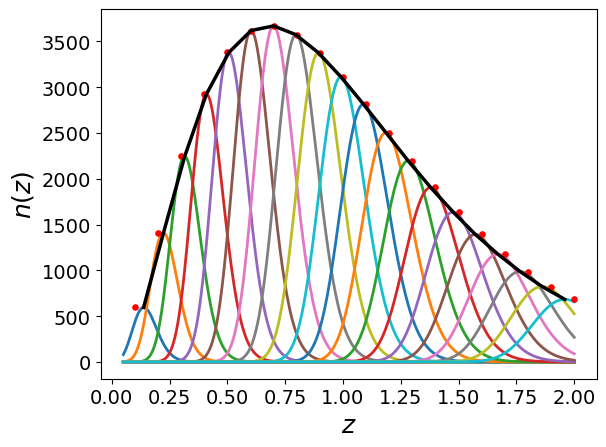

NUmber of lines = 20 

CPU times: user 344 ms, sys: 9.82 ms, total: 353 ms
Wall time: 352 ms


In [8]:
%%time
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)
i_lim = 26.0 
z0 = 0.0417*i_lim - 0.744 
Ngal = 46. * 100.31  * (i_lim - 25.)

Npts = 10**3
all_zs_GD2, all_dNdzs_GD2 , sum_dNdzs2 , arr_z_c2 = Distribution_gauss(0.05, 2, 0.1, Npts, p_z_GD, z0)

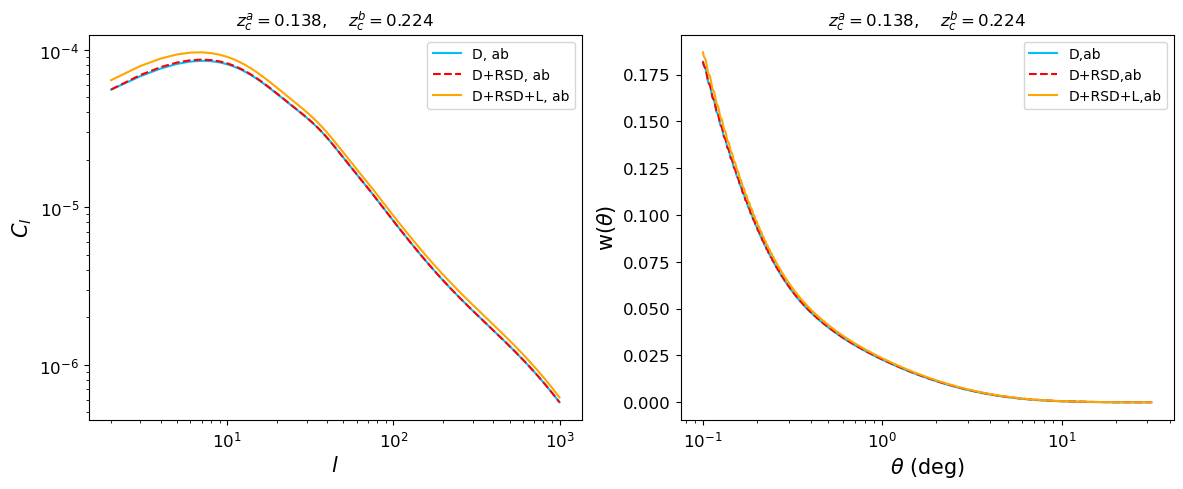

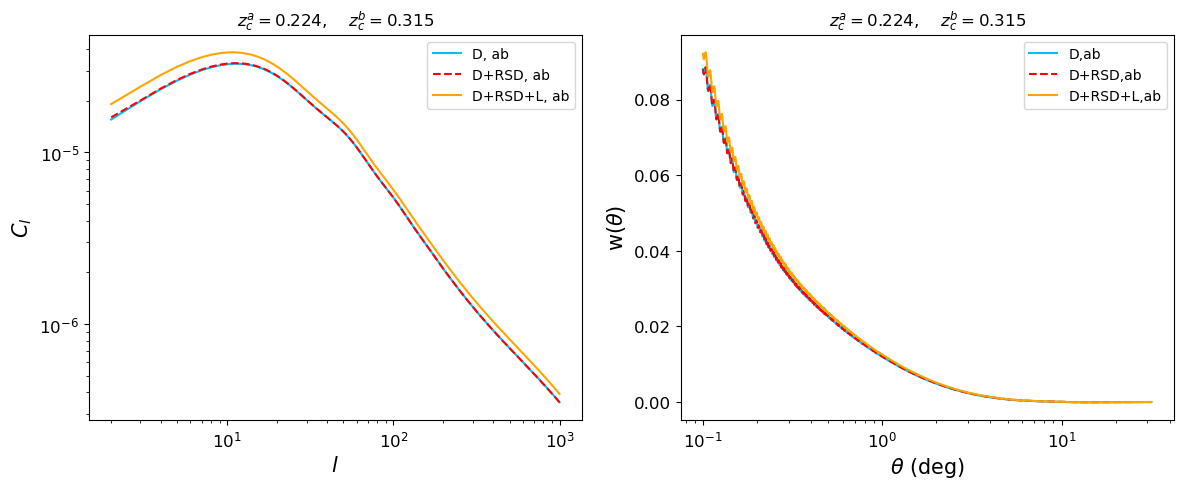

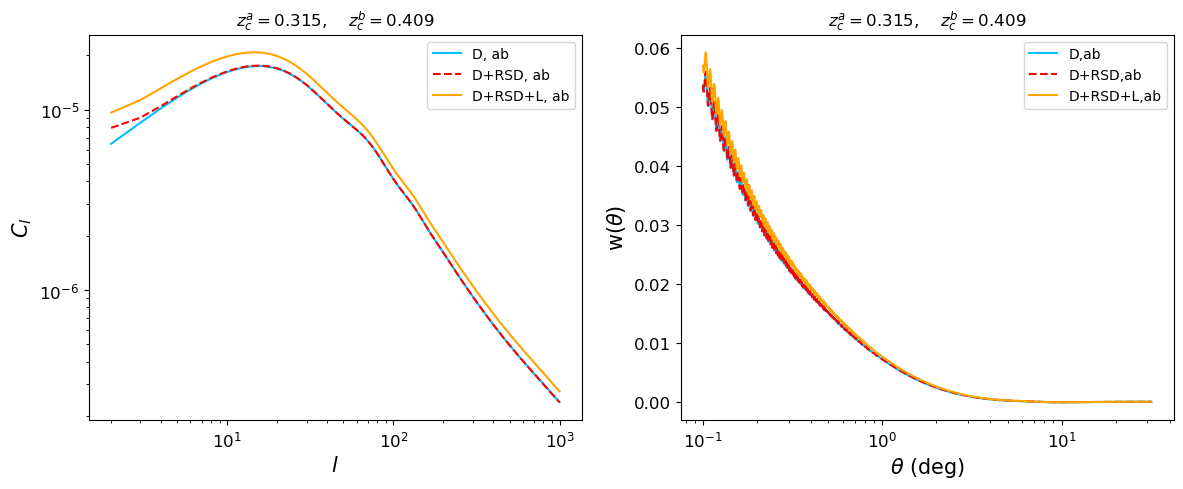

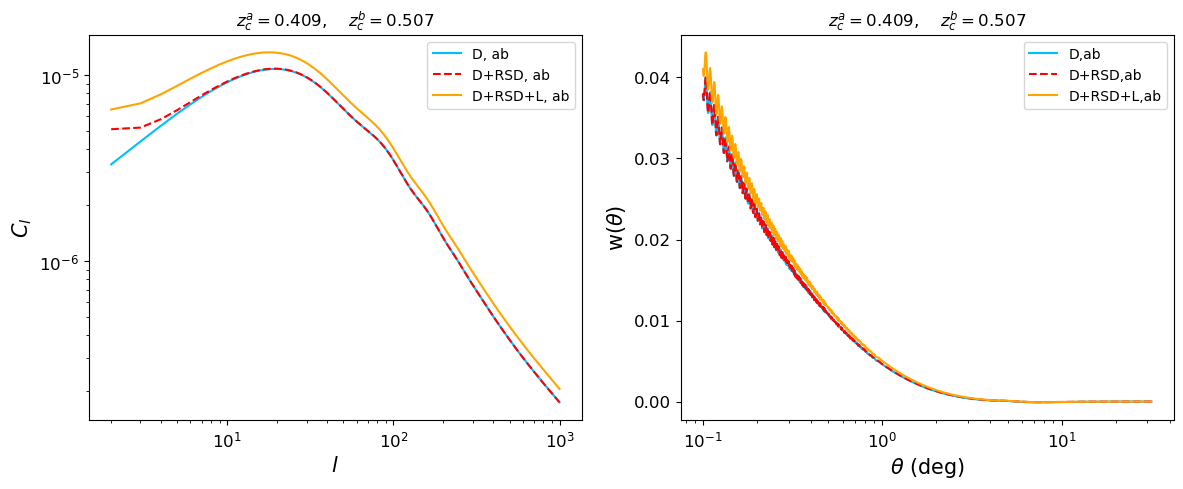

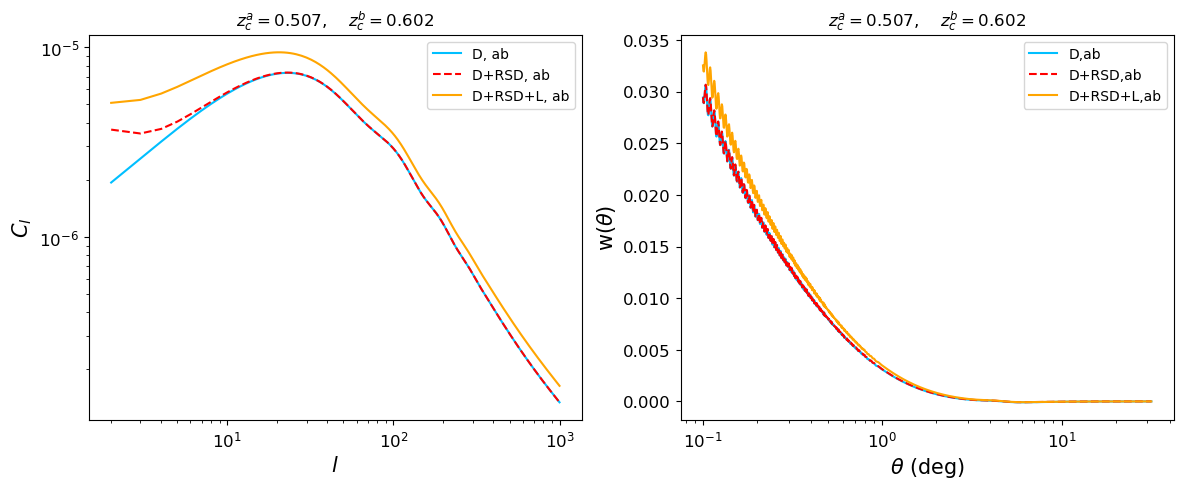

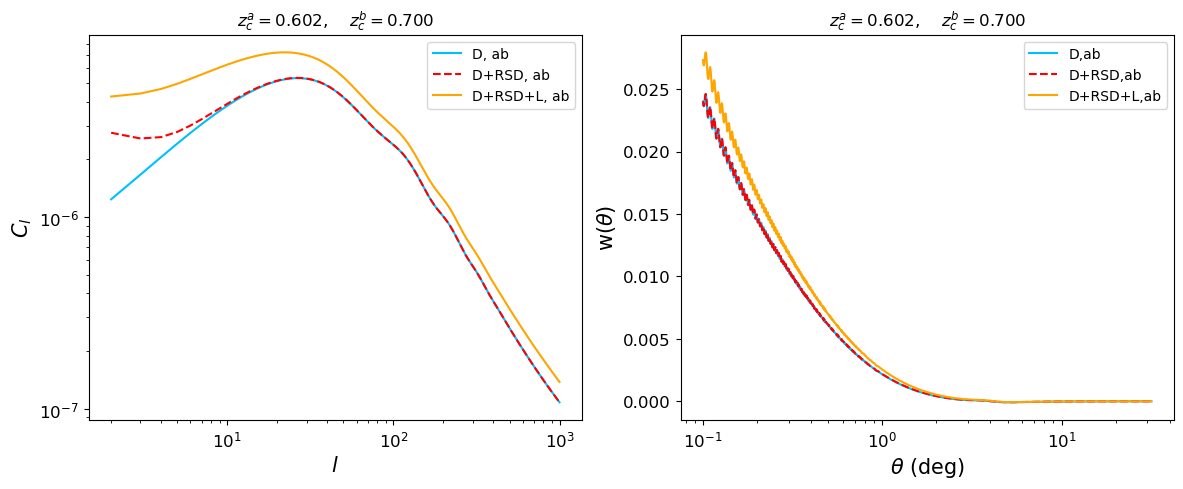

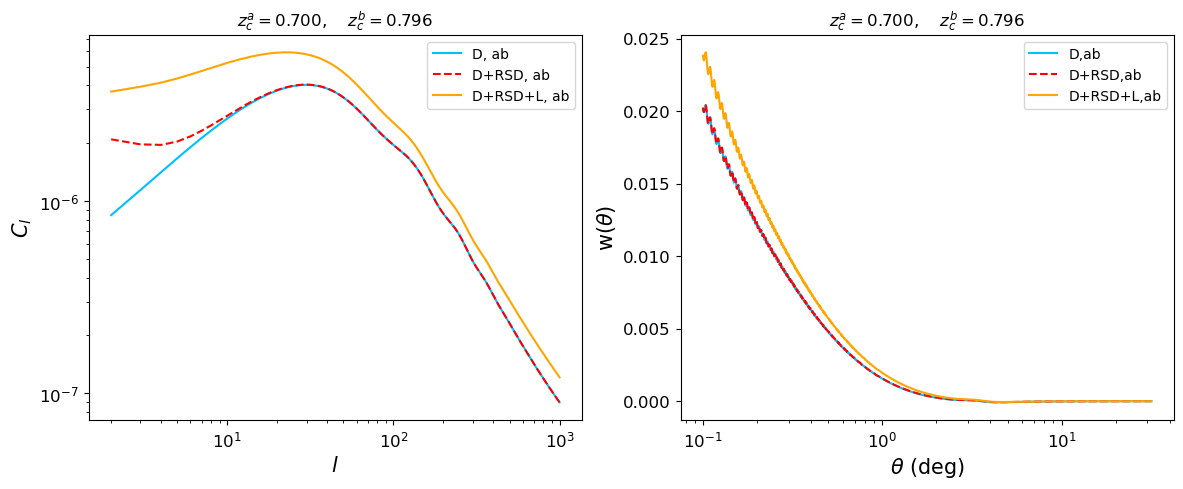

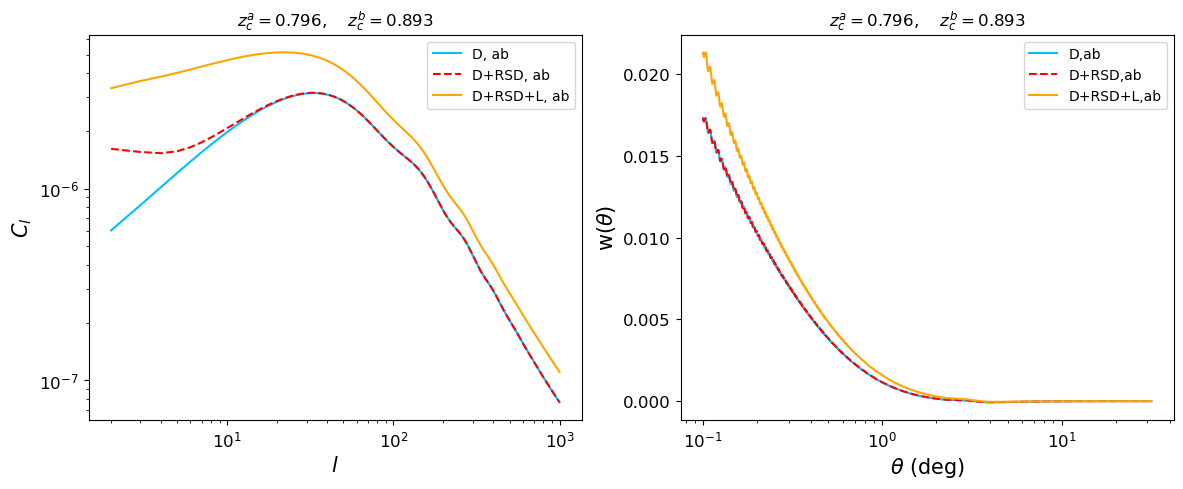

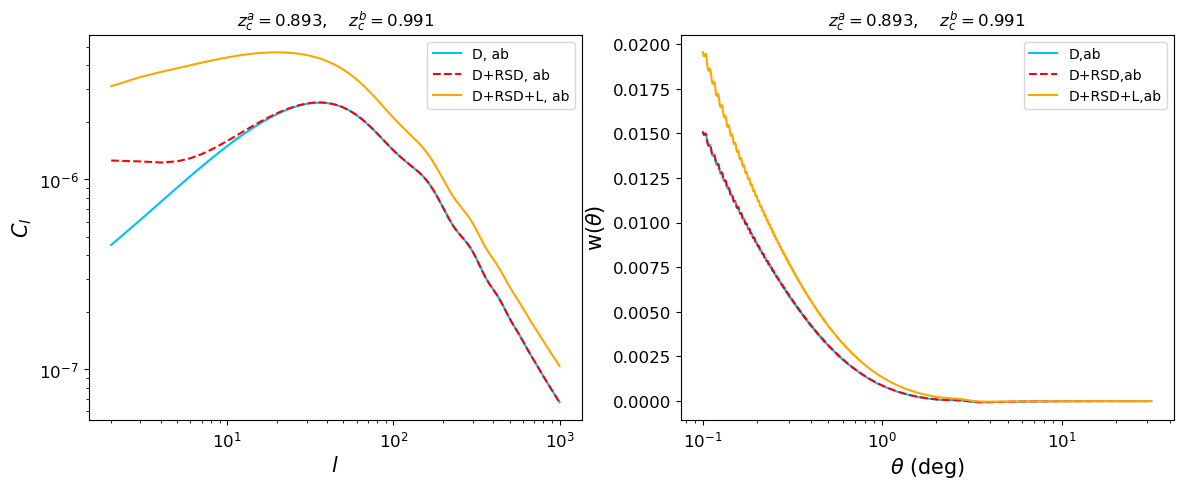

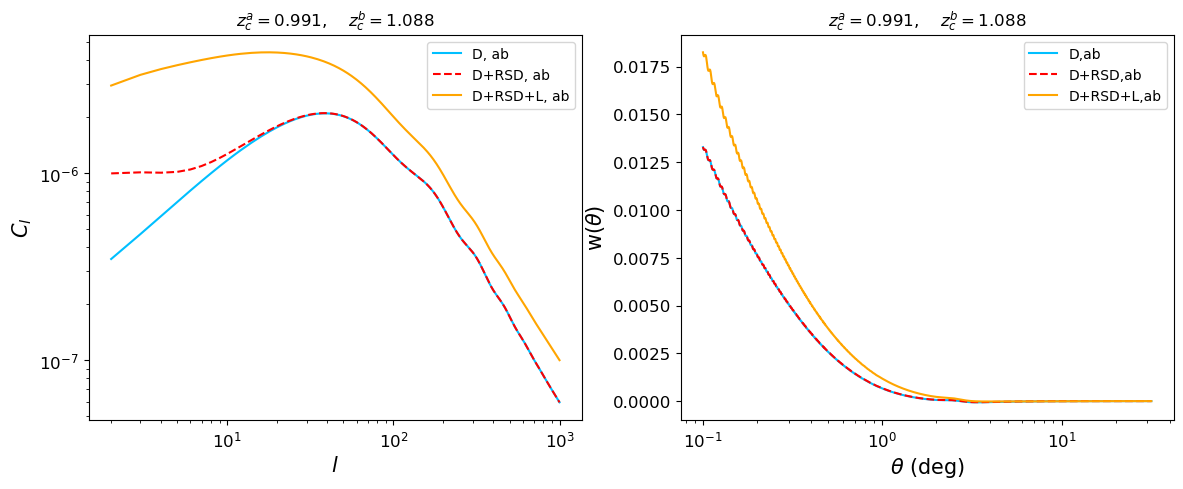

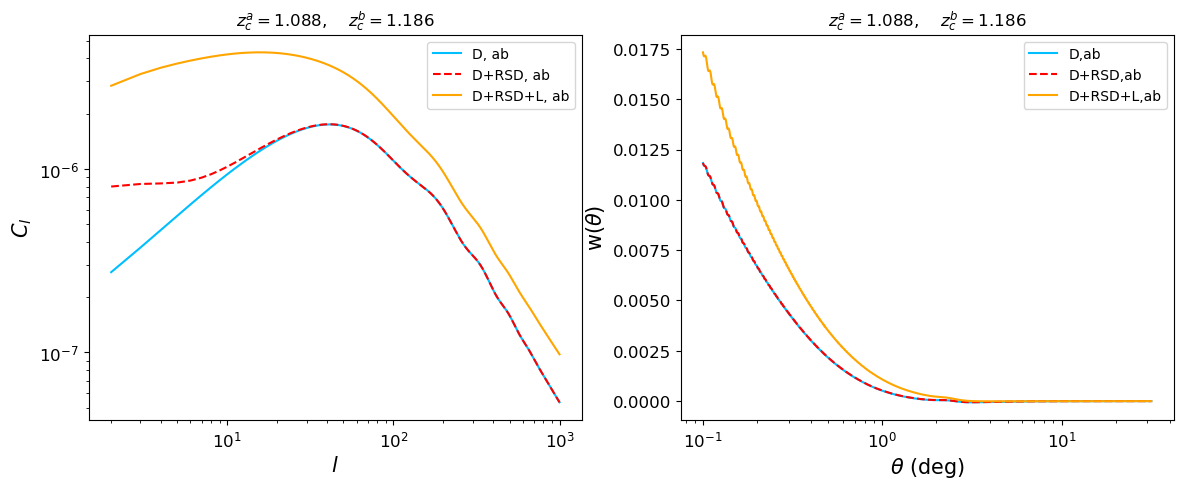

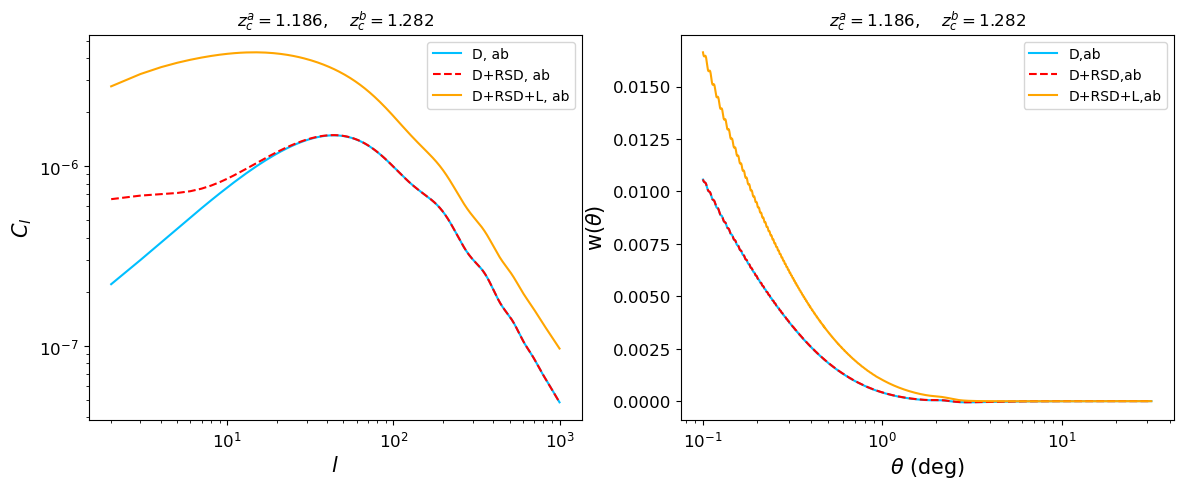

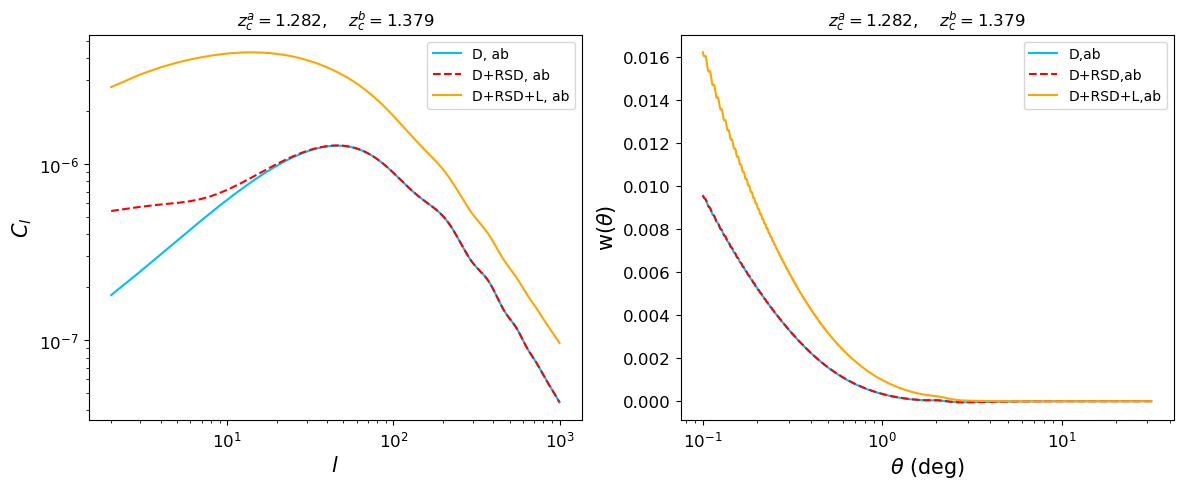

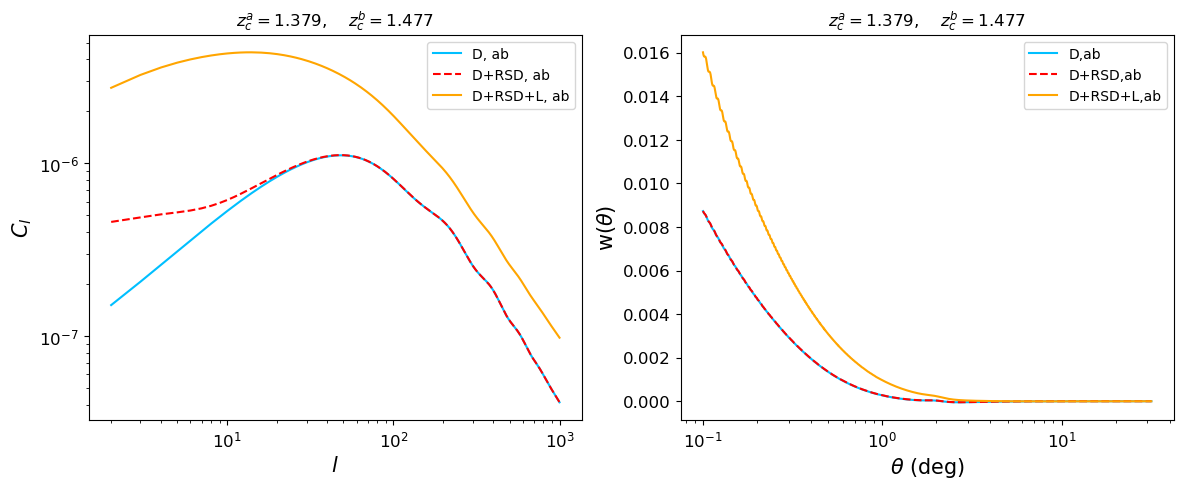

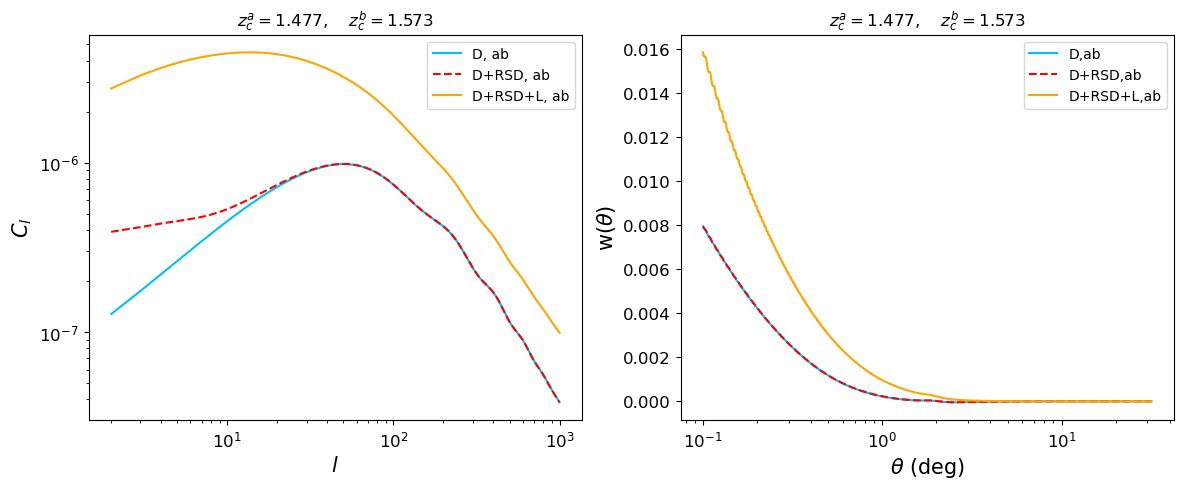

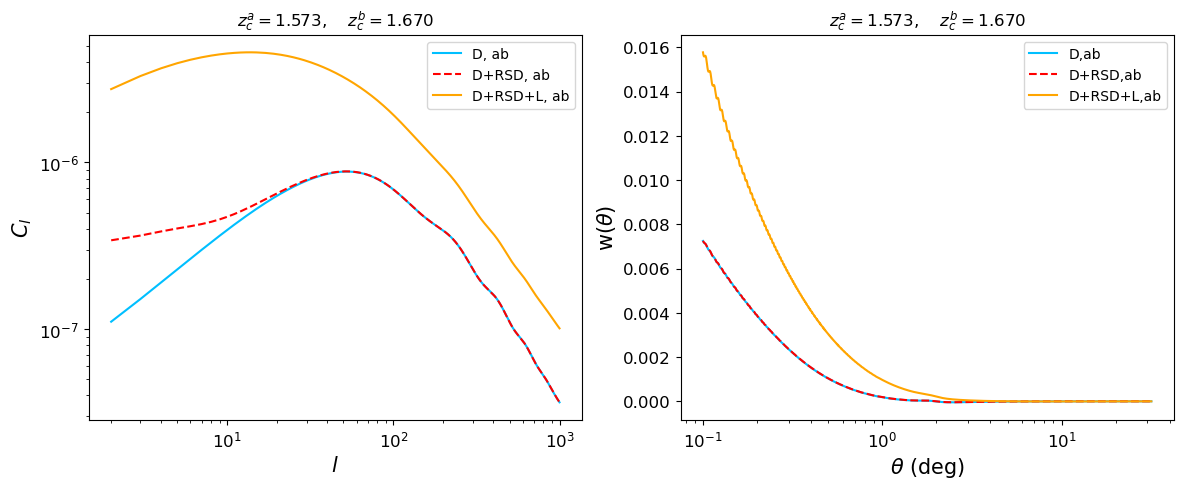

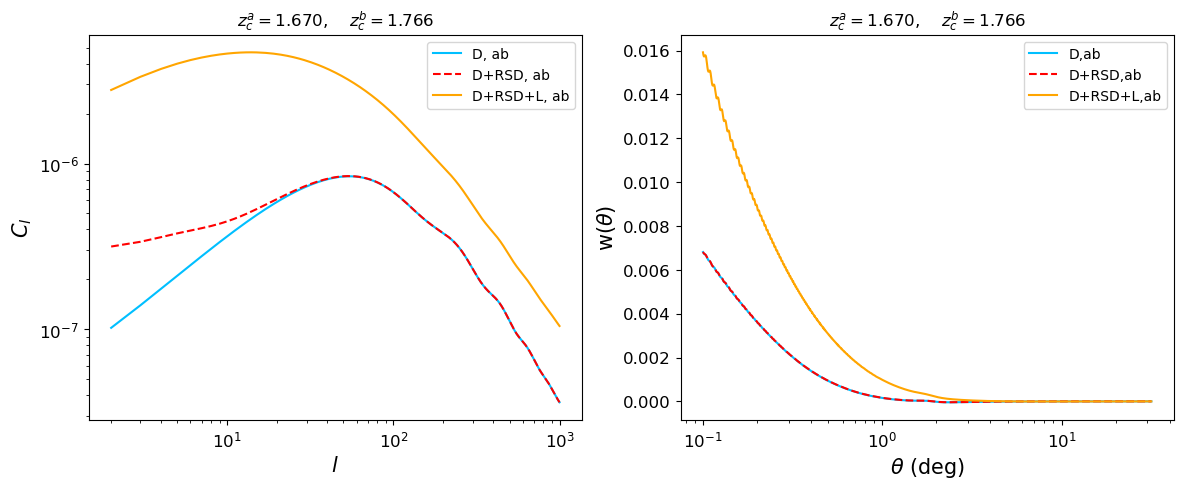

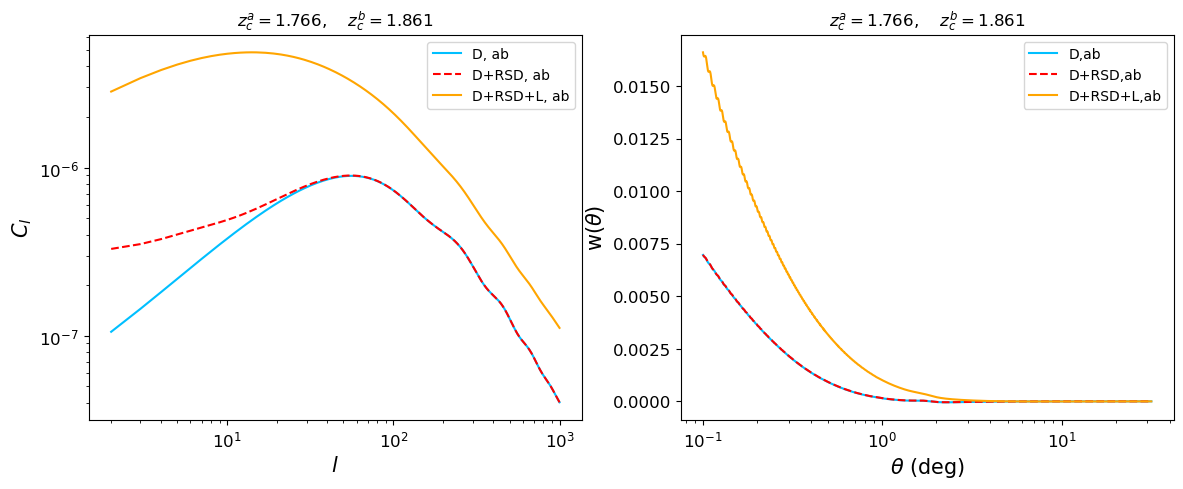

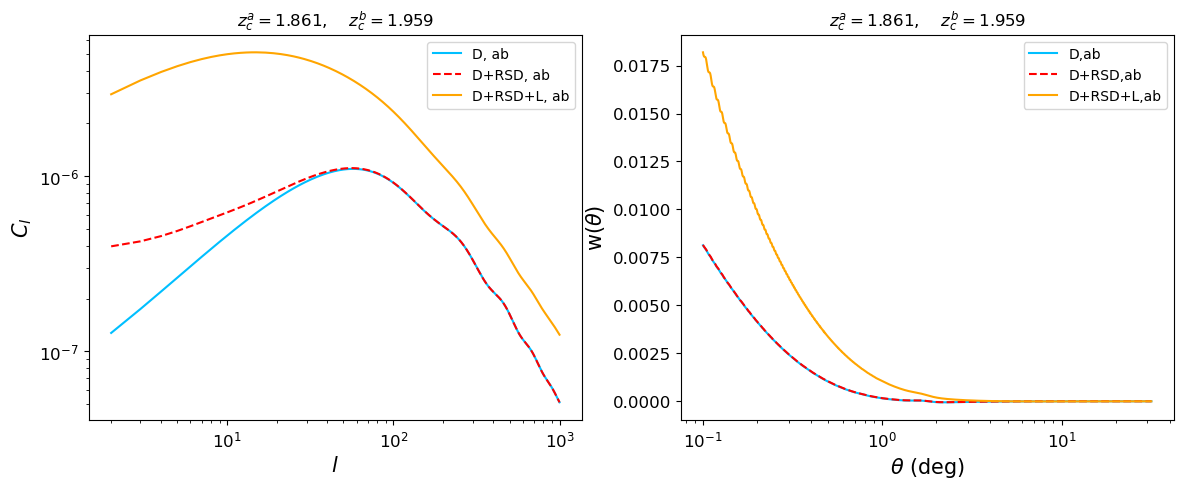

CPU times: user 2min 20s, sys: 687 ms, total: 2min 21s
Wall time: 31.7 s


In [9]:
%%time 
ells2 = np.arange(2, Npts)
thetas2 = np.logspace(-1, 1.5, Npts) 

for i in range( len(arr_z_c2)-1 ):
    index_line_a = i
    index_line_b = i+1
    Tracers_GD2 = Create_Tracers(cosmo, all_zs_GD2, all_zs_GD2, all_dNdzs_GD2[index_line_a], all_dNdzs_GD2[index_line_b], Npts)
    C_ls_GD2    = C_ells(cosmo, Tracers_GD2, ells2)
    ws_GD2      = Ang_Corr(cosmo, ells2, C_ls_GD2, thetas2)
    
    fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
    axis[0].plot(ells2, C_ls_GD2["D_ab"],           c="deepskyblue", label="D, ab")
    axis[0].plot(ells2, C_ls_GD2["D_RSD_ab"], "--", c="red",         label="D+RSD, ab")
    axis[0].plot(ells2, C_ls_GD2["D_RSD_L_ab"],     c="orange",      label="D+RSD+L, ab")
    axis[0].set_xscale('log')
    axis[0].set_yscale('log')
    axis[0].set_xlabel('$l$',fontsize=15)
    axis[0].set_ylabel('$C_l$',fontsize=15)
    axis[0].tick_params(axis='x', labelsize=12)
    axis[0].tick_params(axis='y', labelsize=12)
    axis[0].legend()
    axis[0].set_title(Fr"$z_c^a ={arr_z_c2[index_line_a] :.3f}$, $\quad z_c^b ={arr_z_c2[index_line_b] :.3f} $")
    
    axis[1].plot(thetas2, ws_GD2["D_aa"],          c="deepskyblue", label='D,ab')
    axis[1].plot(thetas2, ws_GD2["D_RSD_aa"],"--", c="red",         label='D+RSD,ab')
    axis[1].plot(thetas2, ws_GD2["D_RSD_L_aa"],    c="orange",      label='D+RSD+L,ab')
    axis[1].set_xscale('log')
    axis[1].set_xlabel(r'$\theta$ (deg)',fontsize=15)
    axis[1].set_ylabel(r'w$(\theta)$',fontsize=15)
    axis[1].tick_params(axis='x', labelsize=12)
    axis[1].tick_params(axis='y', labelsize=12)
    axis[1].legend()
    axis[1].set_title(Fr"$z_c^a ={arr_z_c2[index_line_a] :.3f}$, $\quad z_c^b ={arr_z_c2[index_line_b] :.3f} $")
    plt.show()

Isto não está correto, pois o código PyCCl está a fazer uma Limb approximation.

Esta aproximação não é válida para magnification lensing, ver paper.

### Tentar fazer os $C_l$ s com o CAMB

Using CAMB 1.5.4 installed at /home/tiago_sinde/miniconda3/envs/Linux_env/lib/python3.12/site-packages/camb


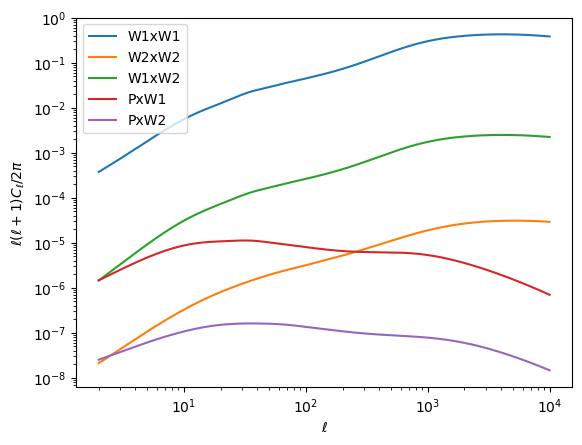

In [10]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(As=2e-9, ns=0.965)


lmax = 10**4
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
#set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = False 
#NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinear = model.NonLinear_both
#Set up W(z) window functions, later labelled W1, W2. Gaussian here.
pars.SourceWindows = [
    GaussianSourceWindow(redshift=0.17, source_type='counts', bias=1.2, sigma=0.04, dlog10Ndm=-0.2),
    GaussianSourceWindow(redshift=0.5, source_type='lensing', sigma=0.07)]

results = camb.get_results(pars)
cls = results.get_source_cls_dict()

#Note that P is CMB lensing, as a deflection angle power (i.e. PxP is [l(l+1)]^2C_l\phi\phi/2\pi)
#lensing window functions are for kappa (and counts for the fractional angular number density)
ls=  np.arange(2, lmax+1)
for spectrum in ['W1xW1','W2xW2','W1xW2',"PxW1", "PxW2"]:
    plt.loglog(ls, cls[spectrum][2:lmax+1], label=spectrum)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend();
plt.show()

In [11]:
#Sources can include various terms using these options (line_xx refers to 21cm)
print(pars.SourceTerms)

class: <SourceTermParams>
 limber_windows = True
 limber_phi_lmin = 100
 counts_density = True
 counts_redshift = True
 counts_lensing = False
 counts_velocity = True
 counts_radial = False
 counts_timedelay = True
 counts_ISW = True
 counts_potential = True
 counts_evolve = False
 line_phot_dipole = False
 line_phot_quadrupole = False
 line_basic = True
 line_distortions = True
 line_extra = False
 line_reionization = False
 use_21cm_mK = True
 


In [23]:
# %%time
# pars = camb.CAMBparams()
# pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
# pars.InitPower.set_params(As=2e-9, ns=0.965)

# lmax = 10**3
# pars.set_for_lmax(lmax, lens_potential_accuracy=1)
# pars.Want_CMB = False                   #set Want_CMB to true if you also want CMB spectra or correlations
# pars.NonLinear = False #model.NonLinear_both   #NonLinear_both or NonLinear_lens will use non-linear corrections

# ls =  np.arange(2, lmax+1)
# arr_zs = np.arange( 0.05, 2, 0.1)
# print("Number of lines:", len(arr_zs) )
# for index in range( len(arr_zs)-1 ):
#     pars.SourceWindows = [GaussianSourceWindow(redshift= arr_zs[index],   source_type='counts', bias=1, sigma=0.05, dlog10Ndm=-0.2),
#                           GaussianSourceWindow(redshift= arr_zs[index+1], source_type='counts', bias=1, sigma=0.05, dlog10Ndm=-0.2)    ]
    
#     pars.SourceTerms.counts_density = True
#     pars.SourceTerms.counts_redshift = False
#     pars.SourceTerms.counts_lensing = False
#     results = camb.get_results(pars)
#     cls = results.get_source_cls_dict()
    
#     pars.SourceTerms.counts_density = True
#     pars.SourceTerms.counts_redshift = True
#     pars.SourceTerms.counts_lensing = False
#     results2 = camb.get_results(pars)
#     cls2 = results2.get_source_cls_dict()
    
#     pars.SourceTerms.counts_density = True
#     pars.SourceTerms.counts_redshift = True
#     pars.SourceTerms.counts_lensing = True
#     results3 = camb.get_results(pars)
#     cls3 = results3.get_source_cls_dict()

#     plt.loglog(ls, cls[ "W1xW2"][2:lmax+1] / (ls*(ls+1)) * 2*np.pi, label='Without')
#     plt.loglog(ls, cls2["W1xW2"][2:lmax+1] / (ls*(ls+1)) * 2*np.pi,"-.", label='With redshift distortions')
#     plt.loglog(ls, cls3["W1xW2"][2:lmax+1] / (ls*(ls+1)) * 2*np.pi,"--",label='With RSD and Lensing ')
#     plt.legend()
#     plt.xlabel(r'$\ell$')
#     plt.ylabel(r'$C_\ell$')
#     # plt.xlim(2,lmax)
#     plt.title(Fr"$z_c^a ={arr_zs[index] :.3f}$, $\quad z_c^b ={arr_zs[index+1] :.3f} $")
#     plt.show()

Number of lines: 20


KeyboardInterrupt: 

No pico de distribuição o lensing passa de ser menos intenso que as restantes componentes para ser mais intenso

O pico de distribuição é aproximadamente pelos z=0.75



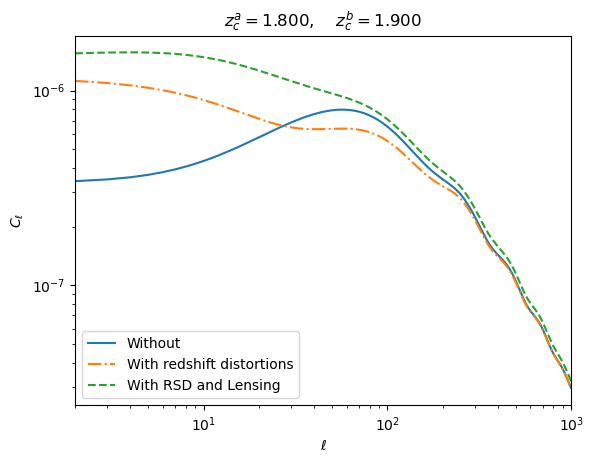

CPU times: user 25.1 s, sys: 90.5 ms, total: 25.2 s
Wall time: 3.54 s


In [9]:
%%time
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(As=2e-9, ns=0.965)

lmax = 10**3
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
pars.Want_CMB, pars.NonLinear = False, False                 

ls =  np.arange(2, lmax+1)
arr_zs = np.arange(0.05, 2, 0.2)

z_a = 1.8
z_b = 1.9
pars.SourceWindows = [GaussianSourceWindow(redshift= z_a, source_type='counts', bias=1, sigma=0.05, dlog10Ndm=-0.2),
                      GaussianSourceWindow(redshift= z_b, source_type='counts', bias=1, sigma=0.05, dlog10Ndm=-0.2)    ]

pars.SourceTerms.counts_density, pars.SourceTerms.counts_redshift, pars.SourceTerms.counts_lensing = True, False, False
results = camb.get_results(pars)
cls = results.get_source_cls_dict()

pars.SourceTerms.counts_density, pars.SourceTerms.counts_redshift, pars.SourceTerms.counts_lensing = True, True, False
results2 = camb.get_results(pars)
cls2 = results2.get_source_cls_dict()

pars.SourceTerms.counts_density, pars.SourceTerms.counts_redshift, pars.SourceTerms.counts_lensing = True, True, True
results3 = camb.get_results(pars)
cls3 = results3.get_source_cls_dict()

plt.loglog(ls, np.abs(cls[ "W1xW2"][2:lmax+1]) / (ls*(ls+1)) * 2*np.pi, label='Without')
plt.loglog(ls, np.abs(cls2["W1xW2"][2:lmax+1]) / (ls*(ls+1)) * 2*np.pi,"-.", label='With redshift distortions')
plt.loglog(ls, np.abs(cls3["W1xW2"][2:lmax+1]) / (ls*(ls+1)) * 2*np.pi,"--",label='With RSD and Lensing ')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xlim(2,lmax)
plt.title(Fr"$z_c^a ={z_a :.3f}$, $\quad z_c^b ={z_b :.3f} $")
plt.show()

Para intervalos de redshift maiores que 0.2, ex: z_a = 0.5, z_b = 0.7,  o CAMB naão consegue calcular os efeitos de lensing

## $C_l$ with CAMB and  $w(\theta)$ with PyCCL

In [6]:
# Calcular Poderes espectrais angulares
def C_ells_Camb(arr_z, ells, z_a, z_b):    
    C_ls = {}
    
    # C_ls aa
    pars.SourceWindows = [GaussianSourceWindow(redshift= z_a, source_type='counts', bias=1, sigma=0.05, dlog10Ndm=-0.2),
                          GaussianSourceWindow(redshift= z_a, source_type='counts', bias=1, sigma=0.05, dlog10Ndm=-0.2) ]
    pars.SourceTerms.counts_density, pars.SourceTerms.counts_redshift, pars.SourceTerms.counts_lensing = True, False, False
    results = camb.get_results(pars)
    C_ls["D_aa"] = results.get_source_cls_dict()
    pars.SourceTerms.counts_density, pars.SourceTerms.counts_redshift, pars.SourceTerms.counts_lensing = True, True, False
    results = camb.get_results(pars)
    C_ls["D_RSD_aa"] = results.get_source_cls_dict()
    pars.SourceTerms.counts_density, pars.SourceTerms.counts_redshift, pars.SourceTerms.counts_lensing = True, True, True
    results = camb.get_results(pars)
    C_ls["D_RSD_L_aa"] = results.get_source_cls_dict()
    
    # C_Ls bb
    pars.SourceWindows = [GaussianSourceWindow(redshift= z_b, source_type='counts', bias=1, sigma=0.05, dlog10Ndm=-0.2),
                          GaussianSourceWindow(redshift= z_b, source_type='counts', bias=1, sigma=0.05, dlog10Ndm=-0.2) ]
    pars.SourceTerms.counts_density, pars.SourceTerms.counts_redshift, pars.SourceTerms.counts_lensing = True, False, False
    results = camb.get_results(pars)
    C_ls["D_bb"] = results.get_source_cls_dict()
    pars.SourceTerms.counts_density, pars.SourceTerms.counts_redshift, pars.SourceTerms.counts_lensing = True, True, False
    results = camb.get_results(pars)
    C_ls["D_RSD_bb"] = results.get_source_cls_dict()
    pars.SourceTerms.counts_density, pars.SourceTerms.counts_redshift, pars.SourceTerms.counts_lensing = True, True, True
    results = camb.get_results(pars)
    C_ls["D_RSD_L_bb"] = results.get_source_cls_dict()
    
    # C_ls ab
    pars.SourceWindows = [GaussianSourceWindow(redshift= z_a, source_type='counts', bias=1, sigma=0.05, dlog10Ndm=-0.2),
                          GaussianSourceWindow(redshift= z_b, source_type='counts', bias=1, sigma=0.05, dlog10Ndm=-0.2) ]
    pars.SourceTerms.counts_density, pars.SourceTerms.counts_redshift, pars.SourceTerms.counts_lensing = True, False, False
    results = camb.get_results(pars)
    C_ls["D_ab"] = results.get_source_cls_dict()
    pars.SourceTerms.counts_density, pars.SourceTerms.counts_redshift, pars.SourceTerms.counts_lensing = True, True, False
    results = camb.get_results(pars)
    C_ls["D_RSD_ab"] = results.get_source_cls_dict()
    pars.SourceTerms.counts_density, pars.SourceTerms.counts_redshift, pars.SourceTerms.counts_lensing = True, True, True
    results = camb.get_results(pars)
    C_ls["D_RSD_L_ab"] = results.get_source_cls_dict()
    return C_ls


# Calcular Função de correlação
def Ang_Corr(cosmo, ells, C_ls, thetas):  
    fator = 1/(ells*(ells+1)) * 2*np.pi
    ws = {}
    ws["D_aa"]       = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_aa"]["W1xW2"][2:ells[-1]+1]*fator,      theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_aa"]   = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_RSD_aa"]["W1xW2"][2:ells[-1]+1]*fator,  theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_L_aa"] = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_RSD_L_aa"]["W1xW2"][2:ells[-1]+1]*fator,theta=thetas, type='NN', method='fftlog')
    
    ws["D_bb"]       = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_bb"]["W1xW2"][2:ells[-1]+1]*fator,      theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_bb"]   = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_RSD_bb"]["W1xW2"][2:ells[-1]+1]*fator,  theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_L_bb"] = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_RSD_L_bb"]["W1xW2"][2:ells[-1]+1]*fator,theta=thetas, type='NN', method='fftlog')
    
    ws["D_ab"]       = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_ab"]["W1xW2"][2:ells[-1]+1]*fator,      theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_ab"]   = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_RSD_ab"]["W1xW2"][2:ells[-1]+1]*fator,  theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_L_ab"] = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_RSD_L_ab"]["W1xW2"][2:ells[-1]+1]*fator,theta=thetas, type='NN', method='fftlog')
    return ws


In [3]:
%%time
Npts = 10**4
ells = np.arange(2, Npts+2, 1)
thetas = np.logspace(-1, 2, Npts) 
arr_zs = np.arange(0.05, 2, 0.2)

z_a = 0.75
z_b = 1.25

# Obtaining Cls form Camb
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(ells[-1], lens_potential_accuracy=1)
pars.Want_CMB, pars.NonLinear = False, False
Cls = C_ells_Camb(arr_zs, ells, z_a, z_b)

# Obtaining ws from PyCCL
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)
w = Ang_Corr(cosmo, ells, Cls, thetas)

CPU times: user 2min 19s, sys: 706 ms, total: 2min 20s
Wall time: 18.8 s


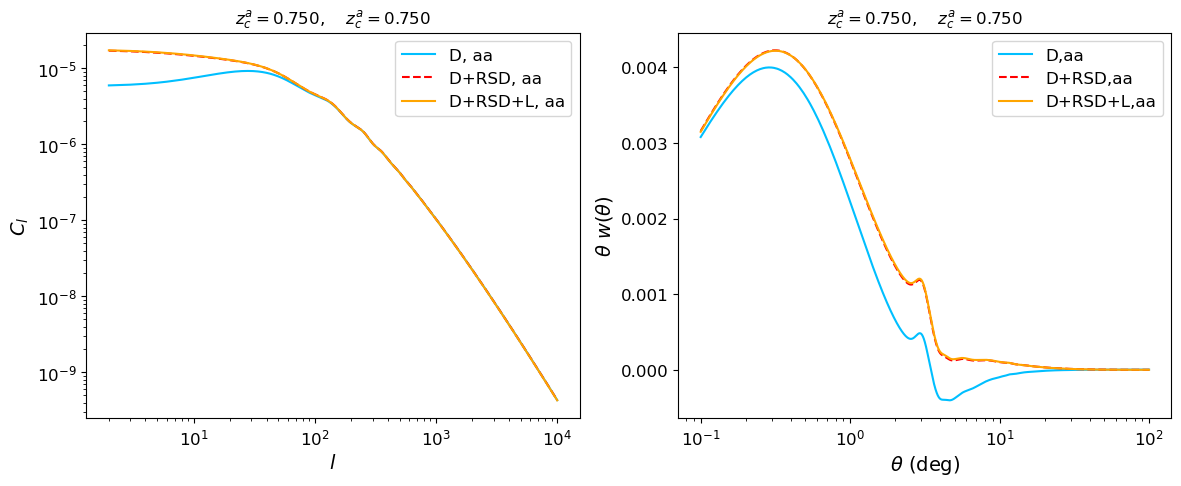

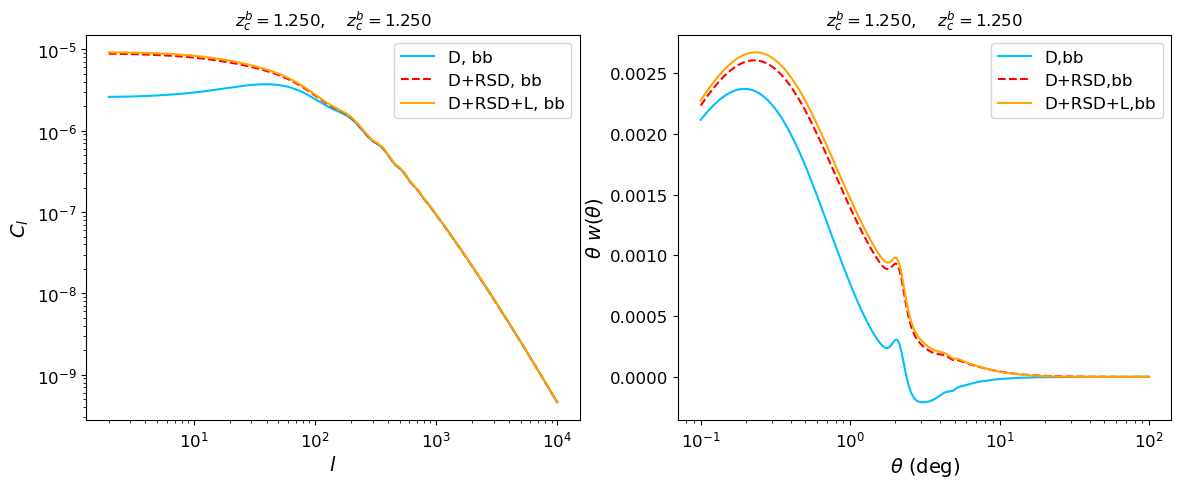

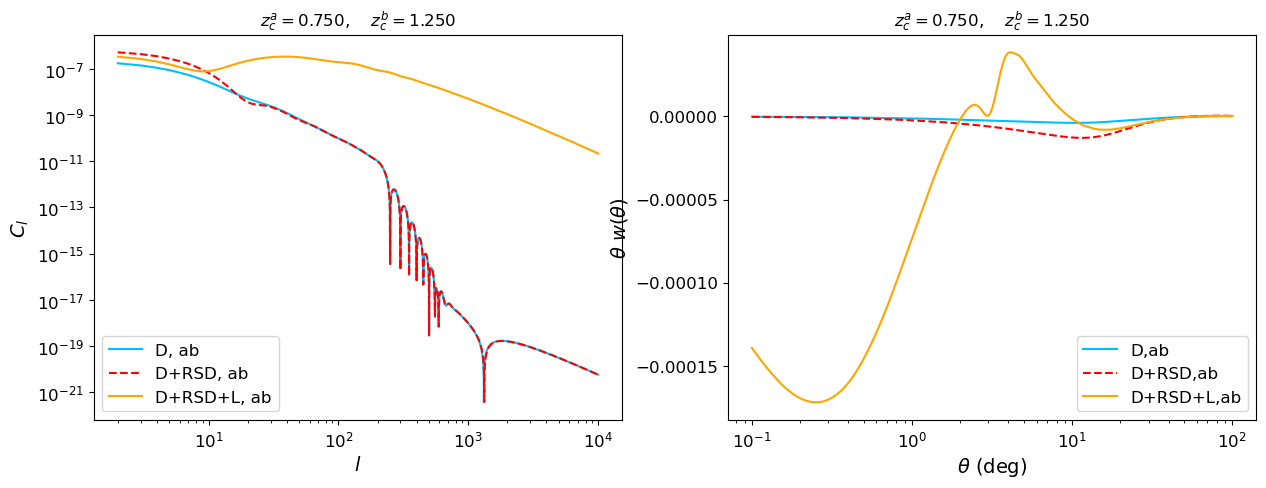

In [4]:
fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, np.abs(Cls["D_aa"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi),           c="deepskyblue", label="D, aa")
axis[0].plot(ells, np.abs(Cls["D_RSD_aa"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi), "--", c="red",         label="D+RSD, aa")
axis[0].plot(ells, np.abs(Cls["D_RSD_L_aa"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi),     c="orange",      label="D+RSD+L, aa")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$')
axis[0].set_ylabel('$C_l$')
axis[0].legend()
axis[0].set_title(Fr"$z_c^a ={z_a :.3f}$, $\quad z_c^a ={z_a :.3f} $")
axis[1].plot(thetas, thetas*w["D_aa"],          c="deepskyblue", label='D,aa')
axis[1].plot(thetas, thetas*w["D_RSD_aa"],"--", c="red",         label='D+RSD,aa')
axis[1].plot(thetas, thetas*w["D_RSD_L_aa"],    c="orange",      label='D+RSD+L,aa')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)')
axis[1].set_ylabel(r'$\theta \ w(\theta)$')
axis[1].legend()
axis[1].set_title(Fr"$z_c^a ={z_a :.3f}$, $\quad z_c^a ={z_a :.3f} $")
plt.show()

fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, np.abs(Cls["D_bb"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi),           c="deepskyblue", label="D, bb")
axis[0].plot(ells, np.abs(Cls["D_RSD_bb"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi), "--", c="red",         label="D+RSD, bb")
axis[0].plot(ells, np.abs(Cls["D_RSD_L_bb"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi),     c="orange",      label="D+RSD+L, bb")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$')
axis[0].set_ylabel('$C_l$')
axis[0].legend()
axis[0].set_title(Fr"$z_c^b ={z_b :.3f}$, $\quad z_c^b ={z_b :.3f} $")
axis[1].plot(thetas, thetas*w["D_bb"],          c="deepskyblue", label='D,bb')
axis[1].plot(thetas, thetas*w["D_RSD_bb"],"--", c="red",         label='D+RSD,bb')
axis[1].plot(thetas, thetas*w["D_RSD_L_bb"],    c="orange",      label='D+RSD+L,bb')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)')
axis[1].set_ylabel(r'$\theta \ w(\theta)$')
axis[1].legend()
axis[1].set_title(Fr"$z_c^b ={z_b :.3f}$, $\quad z_c^b ={z_b :.3f} $")
plt.show()

fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(15,5))
axis[0].plot(ells, np.abs(Cls["D_ab"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi),           c="deepskyblue", label="D, ab")
axis[0].plot(ells, np.abs(Cls["D_RSD_ab"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi), "--", c="red",         label="D+RSD, ab")
axis[0].plot(ells, np.abs(Cls["D_RSD_L_ab"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi),     c="orange",      label="D+RSD+L, ab")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$')
axis[0].set_ylabel('$C_l$')
axis[0].legend()
axis[0].set_title(Fr"$z_c^a ={z_a :.3f}$, $\quad z_c^b ={z_b :.3f} $")
axis[1].plot(thetas, thetas*w["D_ab"],          c="deepskyblue", label='D,ab')
axis[1].plot(thetas, thetas*w["D_RSD_ab"],"--", c="red",         label='D+RSD,ab')
axis[1].plot(thetas, thetas*w["D_RSD_L_ab"],    c="orange",      label='D+RSD+L,ab')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)')
axis[1].set_ylabel(r'$\theta \ w(\theta)$')
axis[1].legend()
axis[1].set_title(Fr"$z_c^a ={z_a :.3f}$, $\quad z_c^b ={z_b :.3f} $")
plt.show()

## $w(\theta)$ error bars

In [64]:
Npts = 10**3
ells = np.arange(2, Npts+2, 1)
thetas = np.logspace(-1, 2, Npts) 
arr_zs = np.arange(0.05, 2, 0.2)

z_a = 0.75
z_b = 1.25
delta_z = abs(z_a-z_b)
# Obtaining Cls form Camb
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(ells[-1], lens_potential_accuracy=1)
pars.Want_CMB, pars.NonLinear = False, False
Cls = C_ells_Camb(arr_zs, ells, z_a, z_b) 
Cl_D_aa = Cls["D_aa"]["W1xW2"][2:ells[-1]+1]*1/(ells*(ells+1)) * 2*np.pi

# Obtaining ws from PyCCL
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)
w = Ang_Corr(cosmo, ells, Cls, thetas)

#################################################

# Determining the w(theta) error bar
dNdz = 5000         # number of galaxies
N = delta_z/dNdz 
f_sky = 1           # part of the sky that we are observing, goes from 0 to 1
delta_l = 10        # bins of size 10 l
err_list = np.zeros(Npts)
teta_list = np.linspace(thetas[0], thetas[-1], 20)
print(teta_list)
for j in range(len(teta_list)):
    w_err_bar = 0
    for index in range(Npts):
    # for index in range(0, Npts, delta_l):
        l = ells[index]
        delta_Cl = np.sqrt( 2 / (2*l + 1) / (f_sky * delta_l)) * (Cl_D_aa[index] + N)
        P_l = sc.special.lpmv(0, l, np.cos( teta_list[j] ))
        w_err_bar += ( (2*l+1)/(4*np.pi) * delta_Cl * P_l )**2
    print(j*50, teta_list[j])
    err_list[j*50] =  w_err_bar
print()
print(err_list[::50])
print()
print(np.max(err_list))

[  0.1          5.35789474  10.61578947  15.87368421  21.13157895
  26.38947368  31.64736842  36.90526316  42.16315789  47.42105263
  52.67894737  57.93684211  63.19473684  68.45263158  73.71052632
  78.96842105  84.22631579  89.48421053  94.74210526 100.        ]
0 0.1
50 5.3578947368421055
100 10.615789473684211
150 15.873684210526317
200 21.131578947368425
250 26.38947368421053
300 31.647368421052636
350 36.905263157894744
400 42.16315789473685
450 47.42105263157895
500 52.678947368421056
550 57.93684210526317
600 63.19473684210527
650 68.45263157894738
700 73.71052631578948
750 78.96842105263158
800 84.22631578947369
850 89.48421052631579
900 94.7421052631579
950 100.0

[8.28556858e-08 1.03688280e-08 8.92428441e-09 5.02250906e-08
 1.09331020e-08 8.71691299e-09 3.61407785e-08 1.16161671e-08
 8.55507963e-09 2.83181424e-08 1.24484193e-08 8.43479350e-09
 2.33605164e-08 1.34725572e-08 8.35318747e-09 1.99524070e-08
 1.47503238e-08 8.30835577e-09 1.74773948e-08 1.63742738e-08]

8.28556858

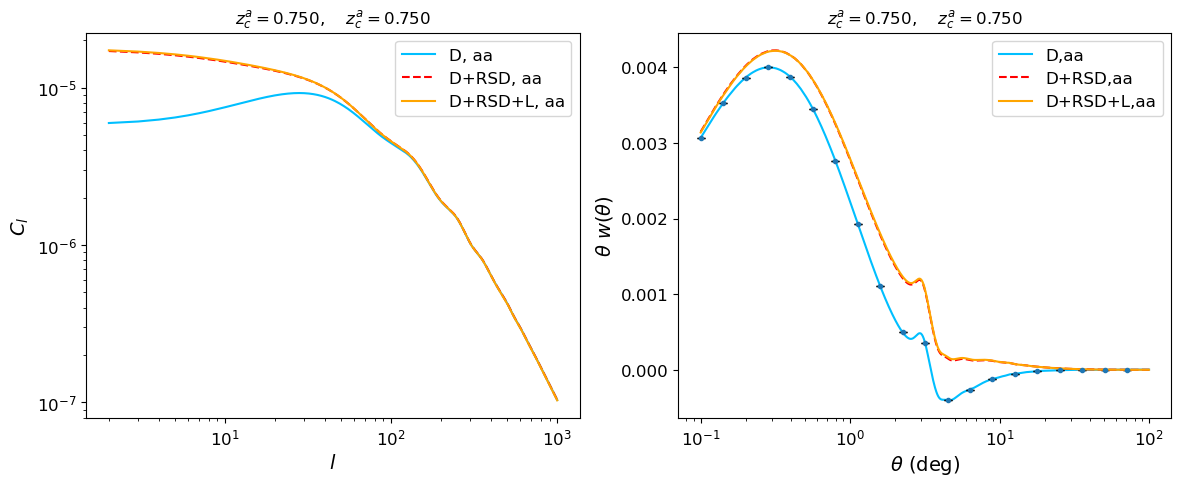

In [50]:
fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, np.abs(Cls["D_aa"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi),           c="deepskyblue", label="D, aa")
axis[0].plot(ells, np.abs(Cls["D_RSD_aa"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi), "--", c="red",         label="D+RSD, aa")
axis[0].plot(ells, np.abs(Cls["D_RSD_L_aa"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi),     c="orange",      label="D+RSD+L, aa")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$')
axis[0].set_ylabel('$C_l$')
axis[0].legend()
axis[0].set_title(Fr"$z_c^a ={z_a :.3f}$, $\quad z_c^a ={z_a :.3f} $")

axis[1].plot(thetas, thetas*w["D_aa"],          c="deepskyblue", label='D,aa')
axis[1].errorbar(thetas[::50], thetas[::50]*w["D_aa"][::50], xerr=None, yerr= err_list[::50], fmt=".", ecolor="k", capsize=3 )

axis[1].plot(thetas, thetas*w["D_RSD_aa"],"--", c="red",         label='D+RSD,aa')
axis[1].plot(thetas, thetas*w["D_RSD_L_aa"],    c="orange",      label='D+RSD+L,aa')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)')
axis[1].set_ylabel(r'$\theta \ w(\theta)$')
axis[1].legend()
axis[1].set_title(Fr"$z_c^a ={z_a :.3f}$, $\quad z_c^a ={z_a :.3f} $")
plt.show()

In [15]:
# Calcular Erro Função de correlação
def Ang_Corr_error(ells, C_ls, thetas, delta_z, f_sky=1, n_pts=20, dNdz=5000):  
    # dNdz      is the number of galaxies
    # f_sky     is part of the sky that we are observing, goes from 0 to 1
    # delta_l   is bins of size ___ l
    
    N = delta_z/dNdz 
    teta_list = np.linspace(thetas[0], thetas[-1], n_pts)
    step = int(len(ells) / n_pts)
    delta_l = step
    
    def calc_w_err(Cl):
        err_list = np.zeros(Npts)
        for j in range(len(teta_list)):
            w_err_bar = 0
            
            for index in range(Npts): # sum in all ls
                l = ells[index]
                delta_Cl = np.sqrt( 2 / (2*l + 1) / (f_sky * delta_l)) * (Cl[index] + N)
                P_l = sc.special.lpmv(0, l, np.cos( teta_list[j] ))
                w_err_bar += ( (2*l+1)/(4*np.pi) * delta_Cl * P_l )**2
            
            err_list[j*step] = w_err_bar
            
        return err_list
    
    fator = 1/(ells*(ells+1)) * 2*np.pi
    w_error = {}
    w_error["D_aa"]       = calc_w_err(C_ls["D_aa"]["W1xW2"][2:ells[-1]+1]*fator   )
    w_error["D_RSD_aa"]   = calc_w_err(C_ls["D_RSD_aa"]["W1xW2"][2:ells[-1]+1]*fator  )
    w_error["D_RSD_L_aa"] = calc_w_err(C_ls["D_RSD_L_aa"]["W1xW2"][2:ells[-1]+1]*fator )
    
    w_error["D_bb"]       = calc_w_err(C_ls["D_bb"]["W1xW2"][2:ells[-1]+1]*fator )
    w_error["D_RSD_bb"]   = calc_w_err(C_ls["D_RSD_bb"]["W1xW2"][2:ells[-1]+1]*fator )
    w_error["D_RSD_L_bb"] = calc_w_err(C_ls["D_RSD_L_bb"]["W1xW2"][2:ells[-1]+1]*fator )
    
    w_error["D_ab"]       = calc_w_err(C_ls["D_ab"]["W1xW2"][2:ells[-1]+1]*fator )
    w_error["D_RSD_ab"]   = calc_w_err(C_ls["D_RSD_ab"]["W1xW2"][2:ells[-1]+1]*fator )
    w_error["D_RSD_L_ab"] = calc_w_err(C_ls["D_RSD_L_ab"]["W1xW2"][2:ells[-1]+1]*fator )
    return w_error, step


In [18]:
Npts = 10**4
ells = np.arange(2, Npts+2, 1)
thetas = np.logspace(-1, 2, Npts) 
arr_zs = np.arange(0.05, 2, 0.2)

z_a = 0.75
z_b = 1.25
delta_z = abs(z_a-z_b)

# Obtaining Cls form Camb
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(ells[-1], lens_potential_accuracy=1)
pars.Want_CMB, pars.NonLinear = False, False
Cls = C_ells_Camb(arr_zs, ells, z_a, z_b) 

# Obtaining ws from PyCCL

cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)
w = Ang_Corr(cosmo, ells, Cls, thetas)

# Obtain errors of ws
w_err, step = Ang_Corr_error(ells, Cls, thetas, delta_z, f_sky=1, n_pts=50, dNdz=5000)
print(step)

200


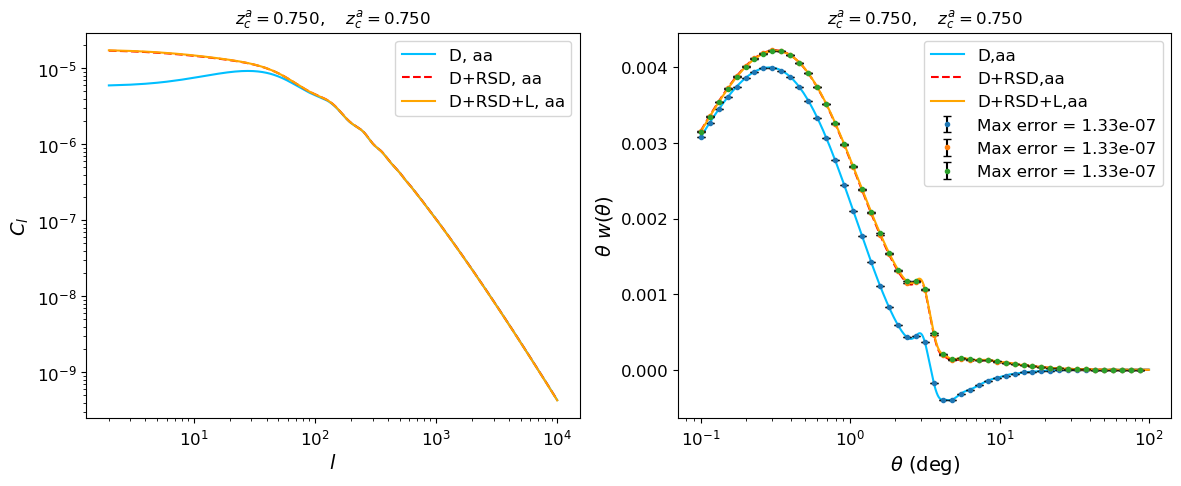

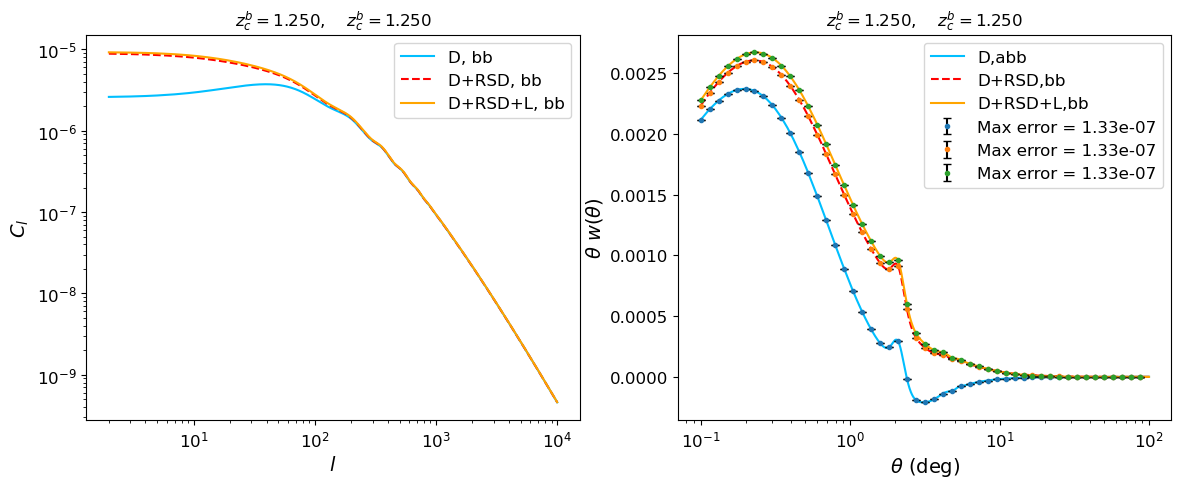

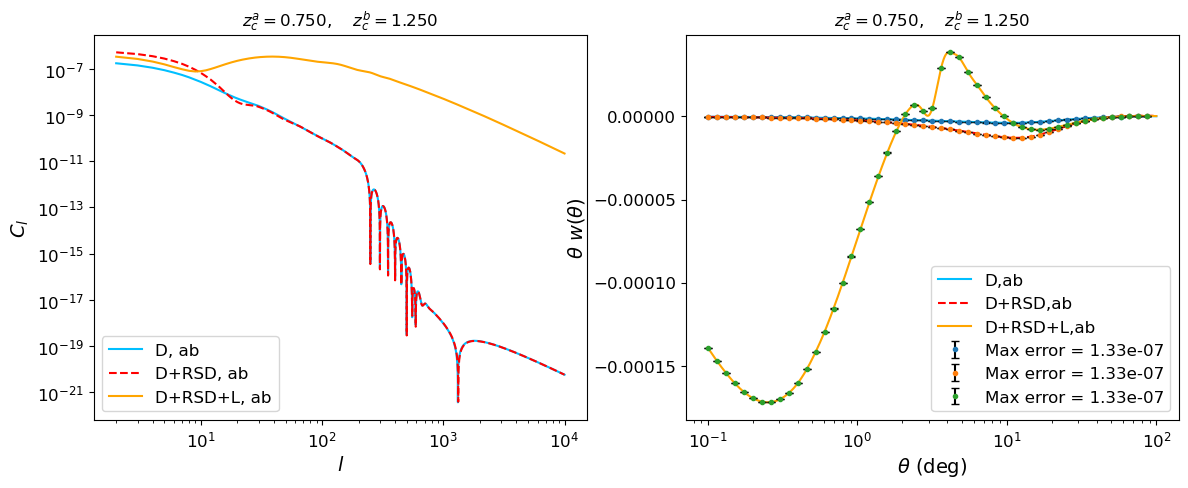

In [25]:
fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, np.abs(Cls["D_aa"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi),           c="deepskyblue", label="D, aa")
axis[0].plot(ells, np.abs(Cls["D_RSD_aa"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi), "--", c="red",         label="D+RSD, aa")
axis[0].plot(ells, np.abs(Cls["D_RSD_L_aa"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi),     c="orange",      label="D+RSD+L, aa")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$')
axis[0].set_ylabel('$C_l$')
axis[0].legend()
axis[0].set_title(Fr"$z_c^a ={z_a :.3f}$, $\quad z_c^a ={z_a :.3f} $")
axis[1].plot(thetas,           thetas*w["D_aa"],                    c="deepskyblue", label='D,aa')
axis[1].errorbar(thetas[::step], thetas[::step]*w["D_aa"][::step],        xerr=None, yerr= w_err["D_aa"][::step], fmt=".", ecolor="k", capsize=2.7, label= F"Max error = {np.max(w_err["D_aa"]):.3}" )
axis[1].plot(thetas,           thetas*w["D_RSD_aa"],"--",           c="red",         label='D+RSD,aa')
axis[1].errorbar(thetas[::step], thetas[::step]*w["D_RSD_aa"][::step],    xerr=None, yerr= w_err["D_RSD_aa"][::step], fmt=".", ecolor="k", capsize=2.7, label= F"Max error = {np.max(w_err["D_RSD_aa"]):.3}" )
axis[1].plot(thetas,           thetas*w["D_RSD_L_aa"],              c="orange",      label='D+RSD+L,aa')
axis[1].errorbar(thetas[::step], thetas[::step]*w["D_RSD_L_aa"][::step],  xerr=None, yerr= w_err["D_RSD_L_aa"][::step], fmt=".", ecolor="k", capsize=2.7, label= F"Max error = {np.max(w_err["D_RSD_L_aa"]):.3}" )
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)')
axis[1].set_ylabel(r'$\theta \ w(\theta)$')
axis[1].legend()
axis[1].set_title(Fr"$z_c^a ={z_a :.3f}$, $\quad z_c^a ={z_a :.3f} $")
plt.show()

fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, np.abs(Cls["D_bb"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi),           c="deepskyblue", label="D, bb")
axis[0].plot(ells, np.abs(Cls["D_RSD_bb"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi), "--", c="red",         label="D+RSD, bb")
axis[0].plot(ells, np.abs(Cls["D_RSD_L_bb"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi),     c="orange",      label="D+RSD+L, bb")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$')
axis[0].set_ylabel('$C_l$')
axis[0].legend()
axis[0].set_title(Fr"$z_c^b ={z_b :.3f}$, $\quad z_c^b ={z_b :.3f} $")
axis[1].plot(thetas, thetas*w["D_bb"],          c="deepskyblue", label='D,abb')
axis[1].errorbar(thetas[::step], thetas[::step]*w["D_bb"][::step], xerr=None, yerr= w_err["D_bb"][::step], fmt=".", ecolor="k", capsize=2.7, label= F"Max error = {np.max(w_err["D_bb"]):.3}" )
axis[1].plot(thetas, thetas*w["D_RSD_bb"],"--", c="red",         label='D+RSD,bb')
axis[1].errorbar(thetas[::step], thetas[::step]*w["D_RSD_bb"][::step], xerr=None, yerr= w_err["D_RSD_bb"][::step], fmt=".", ecolor="k", capsize=2.7, label= F"Max error = {np.max(w_err["D_RSD_bb"]):.3}" )
axis[1].plot(thetas, thetas*w["D_RSD_L_bb"],    c="orange",      label='D+RSD+L,bb')
axis[1].errorbar(thetas[::step], thetas[::step]*w["D_RSD_L_bb"][::step], xerr=None, yerr= w_err["D_RSD_L_bb"][::step], fmt=".", ecolor="k", capsize=2.7, label= F"Max error = {np.max(w_err["D_RSD_L_bb"]):.3}" )
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)')
axis[1].set_ylabel(r'$\theta \ w(\theta)$')
axis[1].legend()
axis[1].set_title(Fr"$z_c^b ={z_b :.3f}$, $\quad z_c^b ={z_b :.3f} $")
plt.show()

fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, np.abs(Cls["D_ab"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi),           c="deepskyblue", label="D, ab")
axis[0].plot(ells, np.abs(Cls["D_RSD_ab"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi), "--", c="red",         label="D+RSD, ab")
axis[0].plot(ells, np.abs(Cls["D_RSD_L_ab"]["W1xW2"][2:ells[-1]+1]/ (ells*(ells+1)) * 2*np.pi),     c="orange",      label="D+RSD+L, ab")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$')
axis[0].set_ylabel('$C_l$')
axis[0].legend()
axis[0].set_title(Fr"$z_c^a ={z_a :.3f}$, $\quad z_c^b ={z_b :.3f} $")
axis[1].plot(thetas, thetas*w["D_ab"],          c="deepskyblue", label='D,ab')
axis[1].errorbar(thetas[::step], thetas[::step]*w["D_ab"][::step], xerr=None, yerr= w_err["D_ab"][::step], fmt=".", ecolor="k", capsize=2.7, label= F"Max error = {np.max(w_err["D_ab"]):.3}" )
axis[1].plot(thetas, thetas*w["D_RSD_ab"],"--", c="red",         label='D+RSD,ab')
axis[1].errorbar(thetas[::step], thetas[::step]*w["D_RSD_ab"][::step], xerr=None, yerr= w_err["D_RSD_ab"][::step], fmt=".", ecolor="k", capsize=2.7, label= F"Max error = {np.max(w_err["D_RSD_ab"]):.3}" )
axis[1].plot(thetas, thetas*w["D_RSD_L_ab"],    c="orange",      label='D+RSD+L,ab')
axis[1].errorbar(thetas[::step], thetas[::step]*w["D_RSD_L_ab"][::step], xerr=None, yerr= w_err["D_RSD_L_ab"][::step], fmt=".", ecolor="k", capsize=2.7, label= F"Max error = {np.max(w_err["D_RSD_L_ab"]):.3}" )
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)')
axis[1].set_ylabel(r'$\theta \ w(\theta)$')
axis[1].legend()
axis[1].set_title(Fr"$z_c^a ={z_a :.3f}$, $\quad z_c^b ={z_b :.3f} $")
plt.show()

# Time

In [14]:
#################################### Tempo total que o programa demora a correr ############################################
t1=time.time()
print("O código do notebook inteiro demorou um total de {} min e {} segundos a correr.".format((t1-T0)//60,int((t1-T0)%60)))

O código do notebook inteiro demorou um total de 1.0 min e 36 segundos a correr.
